# Self-Organizing Map (SOM)

In this notebook SOM architecture is applied to cluster data of AneuRisk database. Patients will be diveded in groups according to geometrical features which characterize their centerlines.

In [151]:
pip install sklearn_som

In [152]:
# avoid to see warnings
import warnings

In [153]:
# upload the libraries
from sklearn_som.som import SOM

from tensorflow.keras.utils import load_img

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats.contingency import association
import scipy.stats
from numpy import diff

In [154]:
# drive connection
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
images_path = "/content/drive/MyDrive/Images_AneuRisk/Arteries/"

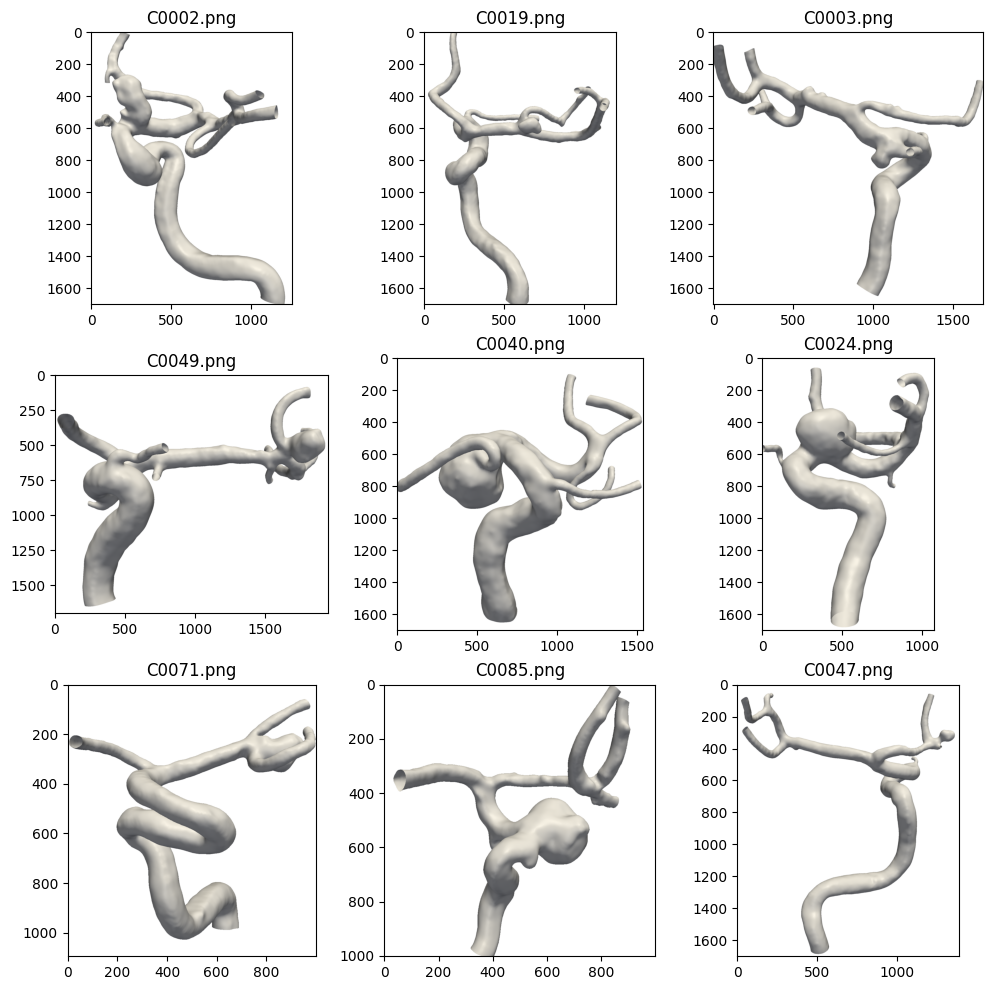

In [156]:
# plot some images
plt.figure(figsize=(12,12))
img = os.listdir(images_path)
to_plot = random.sample(img, 9)
for i in range(9):
    random_image = load_img(images_path + to_plot[i])
    plt.subplot(331 + i)
    plt.title(to_plot[i])
    plt.imshow(random_image)
plt.show()

## Upload dataframes

In [157]:
# upload spline dataframe
spline_df = pd.read_feather("/content/drive/MyDrive/THESIS/spline_df.feather")
spline_df.index = spline_df['ID_patient']
spline_df = spline_df.drop('ID_patient', axis = 1)
spline_df

,Xspline,x,Yspline,y,Zspline,z,s,ID_centerline,Radius
ID_patient,,,,,,,,,
C0001,62.751904,62.751904,3.530136,3.530136,63.179012,63.179012,0.000000,0,1.862776
C0001,62.718945,62.718945,3.624739,3.624739,63.177044,63.177044,0.100199,0,1.858599
C0001,62.683147,62.683147,3.717162,3.717162,63.170528,63.170528,0.199526,0,1.854581
C0001,62.645157,62.645157,3.809958,3.809958,63.161339,63.161339,0.300219,0,1.851056
C0001,62.605400,62.605400,3.901832,3.901832,63.158470,63.158470,0.400366,0,1.847806
...,...,...,...,...,...,...,...,...,...
C0099,45.035614,45.035686,31.131194,31.131193,27.342237,27.342215,89.721208,6,0.421651
C0099,44.994161,44.994141,31.158731,31.158751,27.253737,27.253750,89.822753,6,0.416373
C0099,44.955562,44.955559,31.181678,31.181648,27.164818,27.164810,89.922368,6,0.417277


In [158]:
# upload padded spline dataframe
spline_pad = pd.read_feather("/content/drive/MyDrive/THESIS/pad_spline.feather")
spline_pad.index = spline_pad['ID_patient']
spline_pad = spline_pad.drop(['ID_patient'], axis = 1)
spline_pad

,ID_centerline,Xspline,Yspline,Zspline,s,Radius
ID_patient,,,,,,
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
...,...,...,...,...,...,...
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631


## Perform Curvature Analysis to add it to the Final Dataframe:

In [159]:
# analysis on curvature - c(s) = (x(s), y(s), z(s))

c = np.array([spline_pad['Xspline'].values, spline_pad['Yspline'].values, spline_pad['Zspline'].values])
c = np.transpose(c)
c

array([[62.75190353,  3.53013611, 63.1790123 ],
       [62.75190353,  3.53013611, 63.1790123 ],
       [62.75190353,  3.53013611, 63.1790123 ],
       ...,
       [44.89662933, 31.25234795, 26.98768616],
       [44.89662933, 31.25234795, 26.98768616],
       [44.89662933, 31.25234795, 26.98768616]])

In [160]:
spline = spline_pad

In [161]:
# associate c vectors to the spline dataframe
spline = spline.reset_index()
spline['C'] = np.split(c.flatten(), spline.shape[0])
spline

,ID_patient,ID_centerline,Xspline,Yspline,Zspline,s,Radius,C
0,C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776,"[62.75190353393551, 3.5301361083984353, 63.179..."
1,C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776,"[62.75190353393551, 3.5301361083984353, 63.179..."
2,C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776,"[62.75190353393551, 3.5301361083984353, 63.179..."
3,C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776,"[62.75190353393551, 3.5301361083984353, 63.179..."
4,C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776,"[62.75190353393551, 3.5301361083984353, 63.179..."
...,...,...,...,...,...,...,...,...
882370,C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631,"[44.89662933348336, 31.252347946393343, 26.987..."
882371,C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631,"[44.89662933348336, 31.252347946393343, 26.987..."
882372,C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631,"[44.89662933348336, 31.252347946393343, 26.987..."
882373,C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631,"[44.89662933348336, 31.252347946393343, 26.987..."


In [162]:
# compute the DERIVATIVES

# avoid warnings
warnings.filterwarnings("ignore")

# create a list of ids
ids = spline['ID_patient'].unique().tolist()

# create an empty dataframe
c = pd.DataFrame(columns = ['ID_patient', 'ID_centerline','FirstDerivative', 'SecondDerivative'])

for i in ids:
    # select ith patient
    select = spline[spline.ID_patient == i]
    # find numer of centerlines for each patient
    max_cent = select['ID_centerline'].unique()

    for j in max_cent:
        s = np.vstack(select[select.ID_centerline == j]['s'])

        # compute the c derivative wrt s
        first_der = diff(np.vstack(select[select.ID_centerline == j]['C']), axis = 0) / diff(s, axis = 0)

        # compute second derivative
        sec_der = diff(first_der, axis = 0) / diff(s[:-1], axis = 0)

        # remove NaN
        # given that padding was performed copying the first and last element half times at the beginning and at the end
        # NaN are given by this reason -> having equal number, the diff function has 0 as result
        first_der = np.nan_to_num(first_der, nan = 0)
        sec_der = np.nan_to_num(sec_der, nan = 0)

        c = c.append({'ID_patient': i, 'ID_centerline': j,
                      'FirstDerivative': first_der[:-1],
                      'SecondDerivative': sec_der},
                       ignore_index = True)

In [163]:
# compute the CURVATURE

curvature = []
k = 0
for i in c['ID_patient'].unique():
    # select the ith patient
    select = c[c.ID_patient == i]
    # create a list with all the centerline values
    cent = select['ID_centerline'].unique()

    for j in cent:
        # compute first derivative
        first_derivative = select[select.ID_centerline == j]['FirstDerivative'][k]
        # compute second derivative
        second_derivative = select[select.ID_centerline == j]['SecondDerivative'][k]
        # update the rows counter
        k += 1

        # compute the cross product of the two vectors
        prod = np.cross(first_derivative, second_derivative)
        # compute the norm of the product
        curv = np.linalg.norm(prod, axis = 1)
        # compute denominator (norm of first derivative)
        first_der_3 = np.linalg.norm(first_derivative, axis = 1)
        # compute the final curvature vector
        final_curvature = curv / (first_der_3)**3

        # create the final list
        curvature.append(final_curvature)


# avoid NaN
for i in range(len(curvature)):
    curvature[i] = np.nan_to_num(curvature[i], nan=0)

In [164]:
# associate to each patient and centerline the curvature array
c['Curvature'] = curvature
c

,ID_patient,ID_centerline,FirstDerivative,SecondDerivative,Curvature
0,C0001,0,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C0001,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C0001,2,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C0001,3,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C0001,4,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
538,C0099,2,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
539,C0099,3,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
540,C0099,4,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
541,C0099,5,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [165]:
# compute maximum of curvature vectors
c['Max_Curvature'] = [c.loc[i, 'Curvature'].max() for i in range(c.shape[0])]
c

,ID_patient,ID_centerline,FirstDerivative,SecondDerivative,Curvature,Max_Curvature
0,C0001,0,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.206714
1,C0001,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.816020
2,C0001,2,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.203736
3,C0001,3,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.508741
4,C0001,4,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.236019
...,...,...,...,...,...,...
538,C0099,2,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",43.288949
539,C0099,3,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",40.537715
540,C0099,4,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.268859
541,C0099,5,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.533107


In [166]:
# read the dataframe
df = pd.read_csv("/content/drive/MyDrive/THESIS/dataset.csv")
df

,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory
0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN
1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN
2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN
3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN
4,C0005,NiguardaHospitalMilan,3D-RA,26,F,LAT,ICA,R,False,NaN
...,...,...,...,...,...,...,...,...,...,...
90,C0095,NiguardaHospitalMilan,3D-RA,43,F,TER,BAS,F,False,NaN
91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN
92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN
93,C0098,NiguardaHospitalMilan,3D-RA,59,F,TER,MCA,R,False,NaN


In [167]:
# drop the value with F on ruptureStatus
df = df.drop(df[df.ruptureStatus == 'F'].index, axis = 0)

10 highest value curvature measures for each patient and centerline:

In [168]:
l = []

for i in c.index:
  # order the vector
  sorted_indices = np.argsort(c.loc[i,'Curvature'])[::-1]
  # select the first 10 indexes
  top_10_indices = sorted_indices[:10]
  # select the 10 highest value of curvature
  top_10_curvature_values = c.loc[i,'Curvature'][top_10_indices]
  # compute the mean of the 10 highest value and append it to the list
  l.append(top_10_curvature_values.mean())

In [169]:
# associate the found values to a column in C dataframe
c['Mean of Max 10 Curv Values'] = l

In [170]:
# see C dataframe
c

,ID_patient,ID_centerline,FirstDerivative,SecondDerivative,Curvature,Max_Curvature,Mean of Max 10 Curv Values
0,C0001,0,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.206714,3.110733
1,C0001,1,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.816020,2.595535
2,C0001,2,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.203736,2.570266
3,C0001,3,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.508741,3.036286
4,C0001,4,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.236019,2.708547
...,...,...,...,...,...,...,...
538,C0099,2,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",43.288949,7.256968
539,C0099,3,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",40.537715,7.228051
540,C0099,4,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.268859,4.008822
541,C0099,5,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.533107,3.023753


Associate all the computed measure to the patients dataframe:

In [171]:
# create a new dataframe with each patient and the maxium and the mean curvature value
max_list = []
mean_list = []
curv_list = []
top_mean_list = []
top_max_list = []

for i in df['id'].unique():
    # select the ith patient
    select = c[c.ID_patient == i]
    # compute the maximum curvature within the centerlines
    max_curv = select['Max_Curvature'].max()
    # compute the mean of maximum curvature within the centerlines
    mean_curv = select['Max_Curvature'].mean()
    # add also the curvature vector corresponding to the highest curvature value
    cent = int(select[select.Max_Curvature == max_curv]['ID_centerline'])
    curv = select[select.ID_centerline == cent]['Curvature'].values[0]
    # mean of top average 10 values for each centerline
    mean_top = select['Mean of Max 10 Curv Values'].mean()
    # max of top 10 average values for each centerline
    max_top = select['Mean of Max 10 Curv Values'].max()


    # create the lists
    max_list.append(max_curv)
    mean_list.append(mean_curv)
    curv_list.append(curv)
    top_mean_list.append(mean_top)
    top_max_list.append(max_top)


# create the final new dataframe
df['Max_Curvature'] = max_list
df['Mean_Curvature'] = mean_list
df['Curvature'] = curv_list
df['Mean_Top'] = top_mean_list
df['Max_Top'] = top_max_list
df

,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory,Max_Curvature,Mean_Curvature,Curvature,Mean_Top,Max_Top
0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN,5.206714,3.790571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.669099,3.110733
1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN,12.177532,6.175527,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.005631,3.677076
2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN,5.458297,3.518064,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.307260,2.960496
3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN,9.362738,4.881177,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.887047,3.691017
4,C0005,NiguardaHospitalMilan,3D-RA,26,F,LAT,ICA,R,False,NaN,104.308758,18.477107,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.955328,12.517609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,C0094,NiguardaHospitalMilan,3D-RA,36,F,TER,MCA,R,False,NaN,7.165963,5.126103,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.980576,3.539340
91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN,56.842698,16.939858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.849335,8.251069
92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN,3.535010,3.008104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.478698,3.016430
93,C0098,NiguardaHospitalMilan,3D-RA,59,F,TER,MCA,R,False,NaN,11.901422,5.985927,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.211976,4.356096


Radius:

In [172]:
# compute maximum inscribed radius
radius = []
for i in spline['ID_patient'].unique():
  max_radius = spline[spline.ID_patient == i]['Radius'].max()
  radius.append(max_radius)

In [173]:
# associate the radius measure to a dataframe column
df['Radius'] = radius

Save Results:

In [174]:
# save results
df = df.reset_index()
df.to_feather("/content/drive/MyDrive/THESIS/final_dataset.feather")

## Create the Dataframe and prepare data

In [175]:
# read the dataframe
df = pd.read_feather("/content/drive/MyDrive/THESIS/final_dataset.feather")

In [176]:
# select indexes
ids = spline_df.index.unique()
# create an empty dataframe
sp_df2 = pd.DataFrame(columns = ['ID_patient', 'ID_centerline', 'Xspline', 'Yspline', 'Zspline', 's', 'Radius'])

# avoid warnings
warnings.filterwarnings("ignore")

for i in range(len(ids)):
    # select i-th patient
    select = spline_pad.loc[ids[i], ['ID_centerline', 'Xspline', 'Yspline', 'Zspline', 's', 'Radius']]
    # select maximum number of centerlines
    max_cent = select['ID_centerline'].max()

    for j in range(max_cent+1):
        # create the arrays from the elements of sp_df dataframe for each rows
        x = np.array(select[select.ID_centerline == j]['Xspline'])
        y = np.array(select[select.ID_centerline == j]['Yspline'])
        z = np.array(select[select.ID_centerline == j]['Zspline'])
        s = np.array(select[select.ID_centerline == j]['s'])
        r = np.array(select[select.ID_centerline == j]['Radius'])

        # fill the dataframe
        sp_df2 = sp_df2.append(pd.DataFrame({'ID_patient': ids[i],
                                            'ID_centerline': j,
                                            'Xspline': [x],
                                            'Yspline': [y],
                                            'Zspline': [z],
                                            's': [s],
                                            'Radius': [r]}))

# associate ID_patient to the index
sp_df2.index = sp_df2['ID_patient']
# drop ID_patient column
sp_df2 = sp_df2.drop('ID_patient', axis = 1)

Clean the dataframe:

In [177]:
# drop the two patient with extreme curvature values
sp_df2 = sp_df2.drop(['C0009', 'C0038'], axis = 0)

In [178]:
sp_df2

,ID_centerline,Xspline,Yspline,Zspline,s,Radius
ID_patient,,,,,,
C0001,0,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,1,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858395, 63.17901229858395, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,2,"[62.75190353393553, 62.75190353393553, 62.7519...","[3.5301361083984384, 3.5301361083984384, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,3,"[62.75190353393554, 62.75190353393554, 62.7519...","[3.530136108398436, 3.530136108398436, 3.53013...","[63.179012298583984, 63.179012298583984, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,4,"[62.751903533935476, 62.751903533935476, 62.75...","[3.5301361083984344, 3.5301361083984344, 3.530...","[63.179012298583935, 63.179012298583935, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
...,...,...,...,...,...,...
C0099,2,"[19.37309837341308, 19.37309837341308, 19.3730...","[7.750606060028071, 7.750606060028071, 7.75060...","[51.512187957763636, 51.512187957763636, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612..."
C0099,3,"[19.37309837341309, 19.37309837341309, 19.3730...","[7.750606060028078, 7.750606060028078, 7.75060...","[51.512187957763665, 51.512187957763665, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612..."
C0099,4,"[19.373098373413104, 19.373098373413104, 19.37...","[7.750606060028083, 7.750606060028083, 7.75060...","[51.5121879577637, 51.5121879577637, 51.512187...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612..."


Prepare arrays:

In [179]:
# Create an array containing all the X, Y, Z, s vector values
arr_prova = sp_df2.iloc[:, 1:5].to_numpy()

In [180]:
# modify the array format to get the correct one for SOM algorithm
list_arr = []
for i in range(len(arr_prova)):
  list_arr.append(np.concatenate(arr_prova[i]))

In [181]:
# conver the list into the array and check it
arr = np.array(list_arr)
arr

array([[ 62.75190353,  62.75190353,  62.75190353, ...,  86.41523542,
         86.41523542,  86.41523542],
       [ 62.75190353,  62.75190353,  62.75190353, ...,  86.89853841,
         86.89853841,  86.89853841],
       [ 62.75190353,  62.75190353,  62.75190353, ..., 102.71065966,
        102.71065966, 102.71065966],
       ...,
       [ 19.37309837,  19.37309837,  19.37309837, ...,  94.31348145,
         94.31348145,  94.31348145],
       [ 19.37309837,  19.37309837,  19.37309837, ...,  96.66318733,
         96.66318733,  96.66318733],
       [ 19.37309837,  19.37309837,  19.37309837, ...,  90.12209636,
         90.12209636,  90.12209636]])

In [182]:
# check array shape
arr.shape

(531, 6500)

In [183]:
# fit the scaler
scaler = RobustScaler()
arr = scaler.fit_transform(arr)

## Perform SOM algorithm

In [184]:
# fit the SOM grid
spline_som = SOM(m = 2, n = 2, dim=6500, random_state = 1234, lr = 0.7, max_iter = 20000)
spline_som.fit(arr)

In [185]:
# predict labels
predictions = spline_som.predict(arr)

In [186]:
# add labels to the dataframe
sp_df2['Label'] = predictions

Assocaite one patient with one label:

In [187]:
ids = sp_df2.index.unique()
final_label = []
review = []
to_drop = []
for i in ids:
    # select ith patient
    select = sp_df2[sp_df2.index == i]
    # create a list with the associated label's centerlines
    cent_list = select['Label'].tolist()
    # count all the occurences of the labels
    occurences = dict([(k, cent_list.count(k)) for k in cent_list])
    # determine the label which is mostly present for that patient
    max_value = max(occurences.values())
    # return the keys associated to the maximum value
    max_keys = [key for key, value in occurences.items() if value == max_value]

    # if the maximum in unique, append it to the final list
    if len(max_keys) == 1:
        final_label.append(max_keys)

    # else, raise an error
    else:
        review.append(occurences)
        to_drop.append(i)
        print(f'For patient {i} there is not a unique associated label.')

For patient C0008 there is not a unique associated label.
For patient C0021 there is not a unique associated label.
For patient C0033 there is not a unique associated label.
For patient C0047 there is not a unique associated label.
For patient C0071 there is not a unique associated label.


In [188]:
# check the not added elements
review

[{0: 3, 3: 3},
 {0: 2, 2: 2, 3: 1},
 {0: 4, 3: 4, 2: 1},
 {0: 3, 3: 3},
 {3: 1, 2: 1, 0: 1}]

In [189]:
# drop the patients before
sp_df2 = sp_df2.drop(to_drop, axis = 0)
sp_df2

,ID_centerline,Xspline,Yspline,Zspline,s,Radius,Label
ID_patient,,,,,,,
C0001,0,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",2
C0001,1,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858395, 63.17901229858395, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",2
C0001,2,"[62.75190353393553, 62.75190353393553, 62.7519...","[3.5301361083984384, 3.5301361083984384, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",2
C0001,3,"[62.75190353393554, 62.75190353393554, 62.7519...","[3.530136108398436, 3.530136108398436, 3.53013...","[63.179012298583984, 63.179012298583984, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",2
C0001,4,"[62.751903533935476, 62.751903533935476, 62.75...","[3.5301361083984344, 3.5301361083984344, 3.530...","[63.179012298583935, 63.179012298583935, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",3
...,...,...,...,...,...,...,...
C0099,2,"[19.37309837341308, 19.37309837341308, 19.3730...","[7.750606060028071, 7.750606060028071, 7.75060...","[51.512187957763636, 51.512187957763636, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612...",0
C0099,3,"[19.37309837341309, 19.37309837341309, 19.3730...","[7.750606060028078, 7.750606060028078, 7.75060...","[51.512187957763665, 51.512187957763665, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612...",0
C0099,4,"[19.373098373413104, 19.373098373413104, 19.37...","[7.750606060028083, 7.750606060028083, 7.75060...","[51.5121879577637, 51.5121879577637, 51.512187...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612...",0


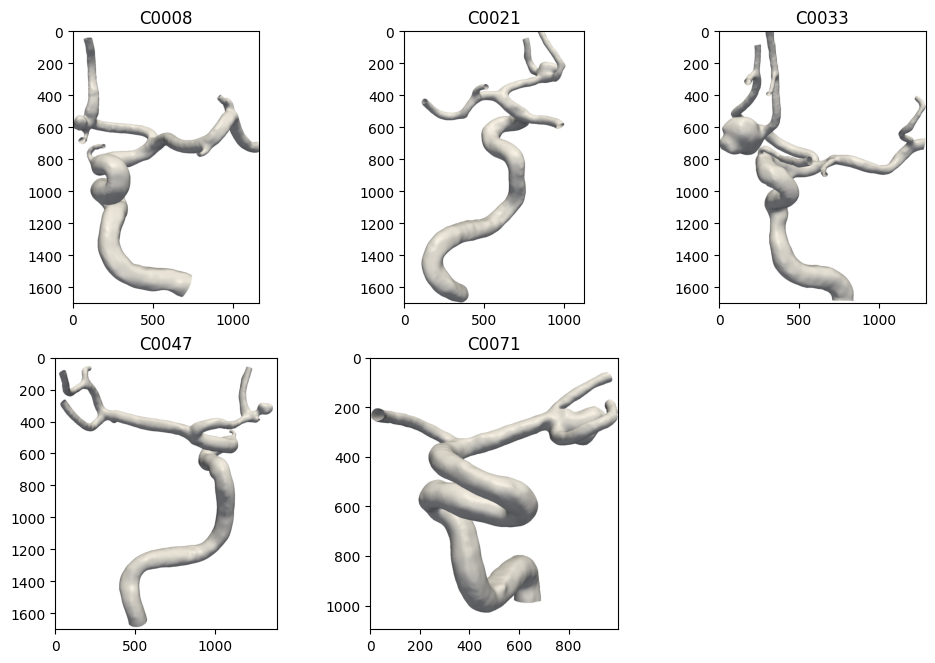

In [190]:
# see graphically the dropped patients
plt.figure(figsize=(12,12))
img = os.listdir(images_path)
# select the dropped patients
to_plot = to_drop
for i in range(len(to_plot)):
    random_image = load_img(images_path + to_plot[i] + '.png')
    plt.subplot(331 + i)
    plt.title(to_plot[i])
    plt.imshow(random_image)
plt.show()

In [191]:
# associate 1 label to each patient
SOM_df = pd.DataFrame({'ID_patient': sp_df2.index.unique(),
                       'Label': np.array(final_label).flatten()})
SOM_df

,ID_patient,Label
0,C0001,2
1,C0002,0
2,C0003,0
3,C0004,0
4,C0005,3
...,...,...
82,C0094,0
83,C0096,0
84,C0097,0
85,C0098,0


In [192]:
# create the final dataframe for SOM algorithm

# create an empty list
to_drop = []
for i in df['id'].tolist():
    # if the index in final_data is not present in final_1, drop it
    if i not in SOM_df['ID_patient'].tolist():
        to_drop.append(i)

# set id column as index
df.index = df['id']
# drop patients defined before
final_SOM = df.drop(to_drop, axis = 0)
# associate the cluster label
final_SOM['Label'] = np.array(final_label).flatten()
final_SOM = final_SOM.reset_index(drop = True)
final_SOM

,index,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory,Max_Curvature,Mean_Curvature,Curvature,Mean_Top,Max_Top,Radius,Label
0,0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN,5.206714,3.790571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.669099,3.110733,2.092899,2
1,1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN,12.177532,6.175527,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.005631,3.677076,2.629028,0
2,2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN,5.458297,3.518064,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.307260,2.960496,1.922469,0
3,3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN,9.362738,4.881177,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.887047,3.691017,1.915786,0
4,4,C0005,NiguardaHospitalMilan,3D-RA,26,F,LAT,ICA,R,False,NaN,104.308758,18.477107,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.955328,12.517609,2.024848,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,89,C0094,NiguardaHospitalMilan,3D-RA,36,F,TER,MCA,R,False,NaN,7.165963,5.126103,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.980576,3.539340,1.745505,0
83,91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN,56.842698,16.939858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.849335,8.251069,1.983498,0
84,92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN,3.535010,3.008104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.478698,3.016430,2.451018,0
85,93,C0098,NiguardaHospitalMilan,3D-RA,59,F,TER,MCA,R,False,NaN,11.901422,5.985927,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.211976,4.356096,2.634574,0


## Create the Cluster and make analysis on them

In [193]:
# create final clusters
cl0_SOM = final_SOM[final_SOM.Label == 0]
cl1_SOM = final_SOM[final_SOM.Label == 1]
cl2_SOM = final_SOM[final_SOM.Label == 2]
cl3_SOM = final_SOM[final_SOM.Label == 3]

**Proportion**:

In [194]:
# create a dataframe to look at distribution proportion
pd.DataFrame({'Cluster 0': [cl0_SOM.shape[0], cl0_SOM.shape[0]/final_SOM.shape[0]],

              'Cluster 1': [cl1_SOM.shape[0], cl1_SOM.shape[0]/final_SOM.shape[0]],

             'Cluster 2': [cl2_SOM.shape[0], cl2_SOM.shape[0]/final_SOM.shape[0]],

              'Cluster 3': [cl3_SOM.shape[0], cl3_SOM.shape[0]/final_SOM.shape[0]]},

              index = ['Number', 'Proportion'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Number,61.000000,0.0,9.000000,17.000000
Proportion,0.701149,0.0,0.103448,0.195402


**Age**:

In [195]:
# AGE

#### compute the mean age for each cluster
mean_cl0 = cl0_SOM['age'].mean()
# mean_cl1 = cl1_SOM['age'].mean()
mean_cl2 = cl2_SOM['age'].mean()
mean_cl3 = cl3_SOM['age'].mean()

# overall mean
overall_mean = final_SOM['age'].mean()

#### comput the mode age for each cluster
mode_cl0 = cl0_SOM['age'].mode().to_list()
# mode_cl1 = cl1_SOM['age'].mode().to_list()
mode_cl2 = cl2_SOM['age'].mode().to_list()
mode_cl3 = cl3_SOM['age'].mode().to_list()

# ovarall mode
overall_mode = final_SOM['age'].mode().to_list()

pd.DataFrame({'Cluster 0': [f'{mean_cl0:.4}', mode_cl0],

              # 'Cluster 1': [f'{mean_cl1:.4}', mode_cl1],

              'Cluster 2': [f'{mean_cl2:.4}', mode_cl2],

              'Cluster 3': [f'{mean_cl3:.4}', mode_cl3],

              'Overall': [f'{overall_mean:.4}', overall_mode]},

              index = ['Mean', 'Mode'])

,Cluster 0,Cluster 2,Cluster 3,Overall
Mean,54.21,51.11,55.71,54.18
Mode,[74],"[38, 53]","[42, 45]","[42, 74]"


Check ANOVA:

In [196]:
# option 1
# check normality
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM['age']),
      '\ncl2: ', scipy.stats.shapiro(cl2_SOM['age']),
      '\ncl3: ', scipy.stats.shapiro(cl3_SOM['age']))

# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):\n'
      'cl0: ', cl0_SOM['age'].std(),
      '\ncl2: ', cl2_SOM['age'].std(),
      '\ncl3: ', cl3_SOM['age'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.9852846264839172, pvalue=0.6747806072235107) 
cl2:  ShapiroResult(statistic=0.9168001413345337, pvalue=0.3664073646068573) 
cl3:  ShapiroResult(statistic=0.9726611375808716, pvalue=0.8631729483604431)


Homogeneity of Variance (std):
cl0:  13.226381155476556 
cl2:  11.252160286412167 
cl3:  14.969822585297866


In [197]:
# apply ANOVA
f_oneway(cl0_SOM['age'], cl2_SOM['age'], cl3_SOM['age'])

F_onewayResult(statistic=0.3461628179444189, pvalue=0.7084016272490017)

**Comment**:

ANOVA does not allow for rejecting the null hypothesis of equal means between clusters.

**Gender**:

In [198]:
# MALE AND FEMALE

# total number of male and female
tot_f = final_SOM.groupby('sex')['sex'].count()[0]
tot_m = final_SOM.groupby('sex')['sex'].count()[1]

# female
nf_0 = cl0_SOM.groupby('sex')['sex'].count()[0]
# nf_1 = cl1_SOM.groupby('sex')['sex'].count()[0]
nf_2 = cl2_SOM.groupby('sex')['sex'].count()[0]
nf_3 = cl3_SOM.groupby('sex')['sex'].count()[0]


# male
nm_0 = cl0_SOM.groupby('sex')['sex'].count()[1]
# nm_1 = cl1_SOM.groupby('sex')['sex'].count()[1]
nm_2 = cl2_SOM.groupby('sex')['sex'].count()[1]
nm_3 = cl3_SOM.groupby('sex')['sex'].count()[1]


pd.DataFrame({'Cluster 0': [nf_0, f'{(nf_0/tot_f)*100:.2f}%', nm_0, f'{(nm_0/tot_m)*100:.2f}%'],

              # 'Cluster 1': [nf_1, f'{(nf_1/tot_f)*100:.2f}%', nm_1, f'{(nm_1/tot_m)*100:.2f}%'],

              'Cluster 2': [nf_2, f'{(nf_2/tot_f)*100:.2f}%', nm_2, f'{(nm_2/tot_m)*100:.2f}%'],

              'Cluster 3': [nf_3, f'{(nf_3/tot_f)*100:.2f}', nm_3, f'{(nm_3/tot_m)*100:.2f}']},

             index = ['F', 'F proportion ', 'M', 'M proportion'])

,Cluster 0,Cluster 2,Cluster 3
F,37,6,12
F proportion,67.27%,10.91%,21.82
M,24,3,5
M proportion,75.00%,9.38%,15.62


X-square test:

In [199]:
contingency_table = pd.crosstab(final_SOM['Label'], final_SOM['sex'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(p_value, chi2)

0.7351376076137638 0.6153951520995881


**Comment**:

X-square test does not confirm any association between sex and clusters, they can be considered as independent.

**Curvature**:

In [200]:
# compute the maximum of the mean
max_mean0 = cl0_SOM['Max_Curvature'].mean()
max_mean1 = cl1_SOM['Max_Curvature'].mean()
max_mean2 = cl2_SOM['Max_Curvature'].mean()
max_mean3 = cl3_SOM['Max_Curvature'].mean()

# compute the mean of the mean
mean_mean0 = cl0_SOM['Mean_Curvature'].mean()
mean_mean1 = cl1_SOM['Mean_Curvature'].mean()
mean_mean2 = cl2_SOM['Mean_Curvature'].mean()
mean_mean3 = cl3_SOM['Mean_Curvature'].mean()

# compute the maximum of the maximum
max_max0 = cl0_SOM['Max_Curvature'].max()
max_max1 = cl1_SOM['Max_Curvature'].max()
max_max2 = cl2_SOM['Max_Curvature'].max()
max_max3 = cl3_SOM['Max_Curvature'].max()

pd.DataFrame({'Cluster 0': [max_mean0, mean_mean0, max_max0],

              'Cluster 1': [max_mean1, mean_mean1, max_max1],

              'Cluster 2': [max_mean2, mean_mean2, max_max2],

              'Cluster 3': [max_mean3, mean_mean3, max_max3]},

              index = ['Mean of Maximum', 'Mean of Mean', 'Max of Maximum'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Mean of Maximum,30.616789,NaN,16.441524,61.338034
Mean of Mean,9.342087,NaN,5.763328,19.766473
Max of Maximum,232.569292,NaN,72.094643,405.219425


In [201]:
# 10 HIGHEST CURVATURES

# compute the maximum of maximum
max_top0 = cl0_SOM['Max_Top'].max()
max_top1 = cl1_SOM['Max_Top'].max()
max_top2 = cl2_SOM['Max_Top'].max()
max_top3 = cl3_SOM['Max_Top'].max()

# compute the mean of maximum
mean_top0 = cl0_SOM['Max_Top'].mean()
mean_top1 = cl1_SOM['Max_Top'].mean()
mean_top2 = cl2_SOM['Max_Top'].mean()
mean_top3 = cl3_SOM['Max_Top'].mean()

# compute the maximum of mean
max_top_mean0 = cl0_SOM['Mean_Top'].max()
max_top_mean1 = cl1_SOM['Mean_Top'].max()
max_top_mean2 = cl2_SOM['Mean_Top'].max()
max_top_mean3 = cl3_SOM['Mean_Top'].max()

# compute the mean of mean
mean_top_mean0 = cl0_SOM['Mean_Top'].mean()
mean_top_mean1 = cl1_SOM['Mean_Top'].mean()
mean_top_mean2 = cl2_SOM['Mean_Top'].mean()
mean_top_mean3 = cl3_SOM['Mean_Top'].mean()

pd.DataFrame({'Cluster 0': [max_top0, mean_top0, max_top_mean0, mean_top_mean0],

              'Cluster 1': [max_top1, mean_top1, max_top_mean1, mean_top_mean1],

              'Cluster 2': [max_top2, mean_top2, max_top_mean2, mean_top_mean2],

              'Cluster 3': [max_top3, mean_top3, max_top_mean3, mean_top_mean3]},

              index = ['Max of Top Max', 'Mean of Top Max', 'Max of Top Mean', 'Mean of Top Mean'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Max of Top Max,25.258339,NaN,9.677956,43.419751
Mean of Top Max,5.667578,NaN,4.193396,8.714813
Max of Top Mean,8.416057,NaN,3.714979,16.381636
Mean of Top Mean,3.242395,NaN,2.946406,4.381937


Check ANOVA assumptions:

In [202]:
# check normality
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM['Max_Curvature']),
      '\ncl2: ', scipy.stats.shapiro(cl2_SOM['Max_Curvature']),
      '\ncl3: ', scipy.stats.shapiro(cl3_SOM['Max_Curvature']))

# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):',
      '\ncl0: ', cl0_SOM['Max_Curvature'].std(),
      '\ncl2: ', cl2_SOM['Max_Curvature'].std(),
      '\ncl3: ', cl3_SOM['Max_Curvature'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.5736836194992065, pvalue=4.890026317899698e-12) 
cl2:  ShapiroResult(statistic=0.6154378652572632, pvalue=0.00014519414980895817) 
cl3:  ShapiroResult(statistic=0.5565745830535889, pvalue=4.070589966431726e-06)


Homogeneity of Variance (std): 
cl0:  50.379021860206386 
cl2:  21.796262907265103 
cl3:  117.3613459960008


*ANOVA assumptions are not respected. Use an alternative test to check if data come from different distributions.*

Kruskal-Wallis H-test:

In [203]:
scipy.stats.kruskal(cl0_SOM['Max_Curvature'],  cl2_SOM['Max_Curvature'],  cl3_SOM['Max_Curvature'])

KruskalResult(statistic=0.17573937089781566, pvalue=0.9158802214668931)

In [204]:
scipy.stats.kruskal(cl0_SOM['Mean_Curvature'], cl2_SOM['Mean_Curvature'], cl3_SOM['Mean_Curvature'])

KruskalResult(statistic=0.28514990627184034, pvalue=0.867122558301487)

**Comment**:

The test does not allow to state that data in the different clusters come from different distributions.

**Rupture** **Status**:

In [205]:
# rupture status

# compute the total number of patients according to the status of the aneurysm
tot_R = final_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[0]
tot_U = final_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[1]

# counts the rupture status' number of patients for each cluster

R_0 = cl0_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[0]
U_0 = cl0_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[1]

# R_1 = cl1_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[0]
# U_1 = cl1_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[1]

R_2 = cl2_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[0]
U_2 = cl2_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[1]

R_3 = cl3_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[0]
U_3 = cl3_SOM.groupby('ruptureStatus')['ruptureStatus'].count()[1]

pd.DataFrame({'Cluster 0': [R_0, f'{(R_0/tot_R)*100:.2f}%',
                                U_0, f'{(U_0/tot_U)*100:.2f}%'],

              # 'Cluster 1': [R_1, f'{(R_1/tot_R)*100:.2f}%',
              #                    U_1, f'{(U_1/tot_U)*100:.2f}%'],

             'Cluster 2': [R_2, f'{(R_2/tot_R)*100:.2f}%',
                                U_2, f'{(U_2/tot_U)*100:.2f}%'],

            'Cluster 3': [R_3, f'{(R_3/tot_R)*100:.2f}%',
                                U_3, f'{(U_3/tot_U)*100:.2f}%']},

             index = ['Ruptured', 'Ruptured proportion', 'Unruptured', 'Unruptured proportion'])

,Cluster 0,Cluster 2,Cluster 3
Ruptured,30,5,2
Ruptured proportion,81.08%,13.51%,5.41%
Unruptured,31,4,15
Unruptured proportion,62.00%,8.00%,30.00%


X-square Test:

In [206]:
# check if there could be an assocaition (Chi-Square Independence test)
contingency_table_SOM = pd.crosstab(final_SOM['Label'], final_SOM['ruptureStatus'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_SOM)
print(p_value, chi2)

0.015672181481047688 8.311736036904792


Cramer's V:

In [207]:
# check association level - Cramer's V
association(contingency_table_SOM, method="cramer")

0.3090909183824265

**Comment**:

X-square results suggests an assocaition between clusters and rupture status. Cramer's V confirms a moderate, not strong, association.

**Perform some plot to better understand data and their subdivision**:

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status - cl1')

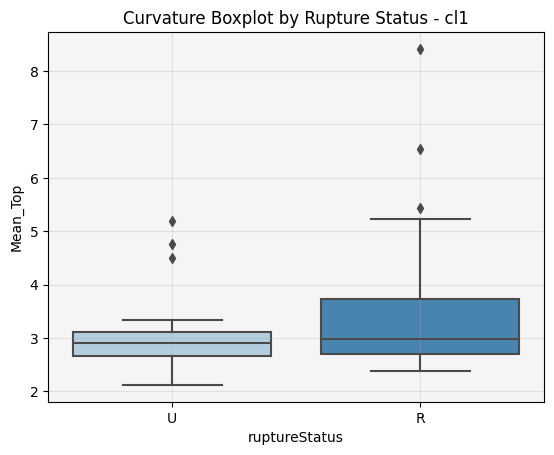

In [208]:
# CLUSTER 0

# select data - curvature data of the mean of the 10 HIGHEST (mean) curvature values
data = cl0_SOM[['Mean_Top', 'ruptureStatus']]

# make the plot
sns.boxplot(x='ruptureStatus', y='Mean_Top', data=data, palette="Blues")
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status - cl1')

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status - cl2')

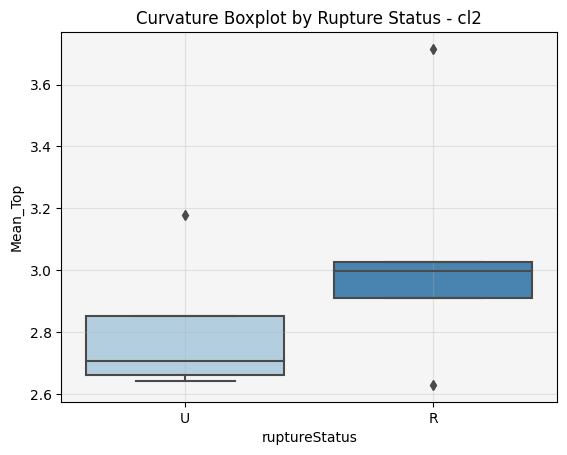

In [209]:
# CLUSTER 2

# select data - curvature data of the mean of the 10 HIGHEST (mean) curvature values
data = cl2_SOM[['Mean_Top', 'ruptureStatus']]

# make the plot
sns.boxplot(x='ruptureStatus', y='Mean_Top', data=data, palette="Blues")
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status - cl2')

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status - cl3')

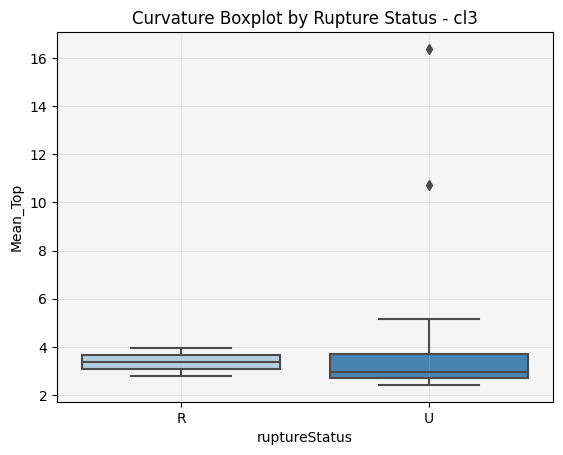

In [210]:
# CLUSTER 3

# select data - curvature data of the mean of the 10 HIGHEST (mean) curvature values
data = cl3_SOM[['Mean_Top', 'ruptureStatus']]

# make the plot
sns.boxplot(x='ruptureStatus', y='Mean_Top', data=data, palette="Blues")
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status - cl3')

**Comment**:

Curvature seems to be higher for unrupted aneurysms only for cluster 3. In cluster 0 and 2 there are no evidences. Probably, other factors are influencing the status of the aneurysms.

**Aneurysm** **Type**:

In [211]:
# aneurysm type

# count the total number of patient per aneurysm type
tot_lat = final_SOM.groupby('aneurysmType')['aneurysmType'].count()[0]
tot_ter = final_SOM.groupby('aneurysmType')['aneurysmType'].count()[1]

# count for each cluster

# LATERAL
lat_0 = cl0_SOM.groupby('aneurysmType')['aneurysmType'].count()[0]
# lat_1 = cl1_SOM.groupby('aneurysmType')['aneurysmType'].count()[0]
lat_2 = cl2_SOM.groupby('aneurysmType')['aneurysmType'].count()[0]
lat_3 = cl3_SOM.groupby('aneurysmType')['aneurysmType'].count()[0]

# TERMINAL
ter_0 = cl0_SOM.groupby('aneurysmType')['aneurysmType'].count()[1]
# ter_1 = cl1_SOM.groupby('aneurysmType')['aneurysmType'].count()[1]
ter_2 = cl2_SOM.groupby('aneurysmType')['aneurysmType'].count()[1]
ter_3 = cl3_SOM.groupby('aneurysmType')['aneurysmType'].count()[1]


pd.DataFrame({'Cluster 0': [lat_0, f'{(lat_0/tot_lat)*100:.2f}%', ter_0, f'{(ter_0/tot_ter)*100:.2f}%'],

              # 'Cluster 1': [lat_1, f'{(lat_1/tot_lat)*100:.2f}%', ter_1, f'{(ter_1/tot_ter)*100:.2f}%']},

             'Cluster 2': [lat_2, f'{(lat_2/tot_lat)*100:.2f}%', ter_2, f'{(ter_2/tot_ter)*100:.2f}%'],

             'Cluster 3': [lat_3, f'{(lat_3/tot_lat)*100:.2f}%', ter_3, f'{(ter_3/tot_ter)*100:.2f}%']},

             index = ['Lateral', 'Lateral proportion', 'Terminal', 'Terminal proportion'])

,Cluster 0,Cluster 2,Cluster 3
Lateral,21,3,12
Lateral proportion,58.33%,8.33%,33.33%
Terminal,40,6,5
Terminal proportion,78.43%,11.76%,9.80%


X-square test:

In [212]:
# contingency table
contingency_table_SOM = pd.crosstab(final_SOM['Label'], final_SOM['aneurysmType'])
# chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table_SOM)
print(p_value, chi2)

0.024292181396502827 7.435201467279294


Cramer's V:

In [213]:
association(contingency_table_SOM, method = 'cramer')

0.29233899129400526

**Comment**:

X-square results suggests an assocaition between clusters and aneurysm type. Cramer's V confirms a moderate, not strong, association.

**Radius**:

In [214]:
# check the radius

# maximum of maximum inscribed radius
max_0 = cl0_SOM['Radius'].max()
max_1 = cl1_SOM['Radius'].max()
max_2 = cl2_SOM['Radius'].max()
max_3 = cl3_SOM['Radius'].max()

# mean of maximum inscribed radius
mean_0 = cl0_SOM['Radius'].mean()
mean_1 = cl1_SOM['Radius'].mean()
mean_2 = cl2_SOM['Radius'].mean()
mean_3 = cl3_SOM['Radius'].mean()

pd.DataFrame({'Cluster 0': [max_0, mean_0],

              'Cluster 1': [max_1, mean_1],

             'Cluster 2': [max_2, mean_2],

             'Cluster 3': [max_3, mean_3]},

             index = ['Max Radius', 'Mean Radius'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Max Radius,3.254167,NaN,3.096853,3.562583
Mean Radius,2.258762,NaN,2.510747,2.650934


In [215]:
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM['Radius']),
      '\ncl2: ', scipy.stats.shapiro(cl2_SOM['Radius']),
      '\ncl3: ', scipy.stats.shapiro(cl3_SOM['Radius']))

# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):',
      '\ncl0: ', cl0_SOM['Radius'].std(),
      '\ncl2: ', cl2_SOM['Radius'].std(),
      '\ncl3: ', cl3_SOM['Radius'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.9811806678771973, pvalue=0.46908190846443176) 
cl2:  ShapiroResult(statistic=0.9618761539459229, pvalue=0.8177424669265747) 
cl3:  ShapiroResult(statistic=0.9489838480949402, pvalue=0.44064855575561523)


Homogeneity of Variance (std): 
cl0:  0.36619100222895656 
cl2:  0.37595166030068056 
cl3:  0.4344130095230055


In [216]:
# ANOVA test
f_oneway(cl0_SOM['Radius'], cl2_SOM['Radius'], cl3_SOM['Radius'])

F_onewayResult(statistic=7.812044695240213, pvalue=0.0007734401164751502)

**Comment**:

ANOVA test allow for rejecting the null htpothesis of equal means. So, means can be considered statistically different between clusters.

**Radius Plot**:

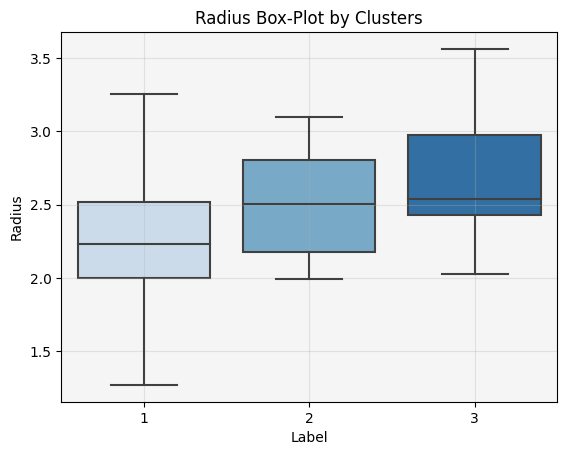

In [217]:
# select the data
data = final_SOM[['Radius', 'Label']]

# make the plot
sns.boxplot(x='Label', y='Radius', data=data, palette="Blues")
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Radius Box-Plot by Clusters')

plt.xticks([0, 1, 2], ['1', '2', '3'])

plt.show()

**Comment**:

The radius is clearly increasing. Cluster 1 presents the wider range, it is prevedible due to the higher number of observation. Cluster 3 presents the highest values.

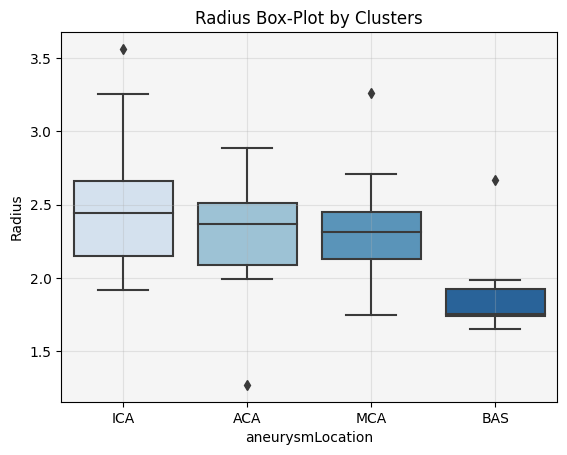

In [218]:
# select the data
data = final_SOM[['Radius', 'aneurysmLocation']]

# make the plot
sns.boxplot(x='aneurysmLocation', y='Radius', data=data, palette="Blues")
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Radius Box-Plot by Clusters')

plt.show()

**Comment**:

ICA radius is generally the wider, also considering the higher number of patients having an anuerysm on it. ACA and MCA are similar, while BAS presents the lower radius values.

**AneurysmLocation:**

In [219]:
# aneurysm location

# count the total number of patient per aneurysm location
tot_aca = final_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]
tot_bas = final_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
tot_ica = final_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]
tot_mca = final_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[3]


# count for each cluster

# ACA
aca_0 = cl0_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]
# aca_1 = cl1_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]
aca_2 = cl2_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]
aca_3 = cl3_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]

# BAS
bas_0 = cl0_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
# bas_1 = cl1_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
# bas_2 = cl2_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
# bas_3 = cl3_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]

# ICA
ica_0 = cl0_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]
# ica_1 = cl1_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]
ica_2 = cl2_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
ica_3 = cl3_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]

# MCA
mca_0 = cl0_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[3]
# mca_1 = cl1_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[3]
mca_2 = cl2_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]
mca_3 = cl3_SOM.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]

pd.DataFrame({'Cluster 0': [aca_0, f'{(aca_0/tot_aca)*100:.2f}%', bas_0, f'{(bas_0/tot_bas)*100:.2f}%', ica_0, f'{(ica_0/tot_ica)*100:.2f}%', mca_0, f'{(mca_0/tot_mca)*100:.2f}%'],

              # 'Cluster 1': [aca_1, f'{(aca_1/tot_aca)*100:.2f}%', bas_1, f'{(bas_1/tot_bas)*100:.2f}%', ica_1, f'{(ica_1/tot_ica)*100:.2f}%', mca_1, f'{(mca_1/tot_mca)*100:.2f}%'],

             'Cluster 2': [aca_2, f'{(aca_2/tot_aca)*100:.2f}%', 0, f'{(0/tot_bas)*100:.2f}%', ica_2, f'{(ica_2/tot_ica)*100:.2f}%', mca_2, f'{(mca_2/tot_mca)*100:.2f}%'],

             'Cluster 3': [aca_3, f'{(aca_3/tot_aca)*100:.2f}%', 0, f'{(0/tot_bas)*100:.2f}%', ica_3, f'{(ica_3/tot_ica)*100:.2f}%', mca_3, f'{(mca_3/tot_mca)*100:.2f}%']},

             index = ['ACA', 'ACA Proportion', 'BAS', 'BAS Proportion', 'ICA', 'ICA Proportion', 'MCA', 'MCA Proportion'])

,Cluster 0,Cluster 2,Cluster 3
ACA,14,3,1
ACA Proportion,77.78%,16.67%,5.56%
BAS,6,0,0
BAS Proportion,100.00%,0.00%,0.00%
ICA,24,5,13
ICA Proportion,57.14%,11.90%,30.95%
MCA,17,1,3
MCA Proportion,80.95%,4.76%,14.29%


X-squared Test:

In [220]:
contingency_table_SOM = pd.crosstab(final_SOM['Label'], final_SOM['aneurysmLocation'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_SOM)
print(p_value, chi2)

0.10906919054243731 10.39243238278918


Cramer's V:

In [221]:
association(contingency_table_SOM, method = 'cramer')

0.24439030850177546

**Comment**:

X-squared test confirms the statistical independence between clusters and anuerysm location.

**Understand in more details:**

Rupture Status by Cluster:

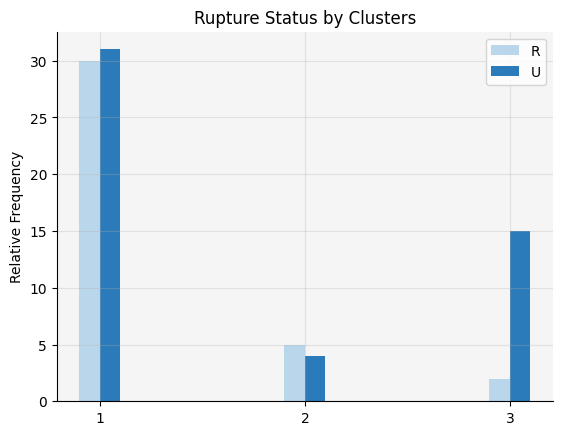

In [222]:
# select the data
data = pd.crosstab(final_SOM['ruptureStatus'], final_SOM['Label'])

# select label categories
types = ("Cl. 0", "Cl. 1", "Cl. 2")
# create a dictionary containing the numer of ruptured and unruptured by label
values = {'R': data.values[0].tolist(),
          'U': data.values[1].tolist()}

x = np.arange(len(types))  # the label of clusters
width = 0.1  # the width of the bars

fig, ax = plt.subplots()

# create the color palettes
ruptured_color = sns.color_palette("Blues")[1]
unruptured_color = sns.color_palette("Blues")[4]

# plot the bars for ruptured
ax.bar(x - width/2, values['R'], width, label='R', color=ruptured_color)
# plot the bars for unruptured
ax.bar(x + width/2, values['U'], width, label='U', color=unruptured_color)

ax.set_ylabel('Relative Frequency')
ax.set_title('Rupture Status by Clusters')
ax.set_xticks(x)
ax.set_xticklabels(types)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
ax.legend()
plt.xticks([0, 1, 2], ['1', '2', '3'])

plt.show()

**Comment**:

Higher number of unrupted in cluster 3, which correspond to the cluster with highest curvature.

Check clusters and aneurysm locations:

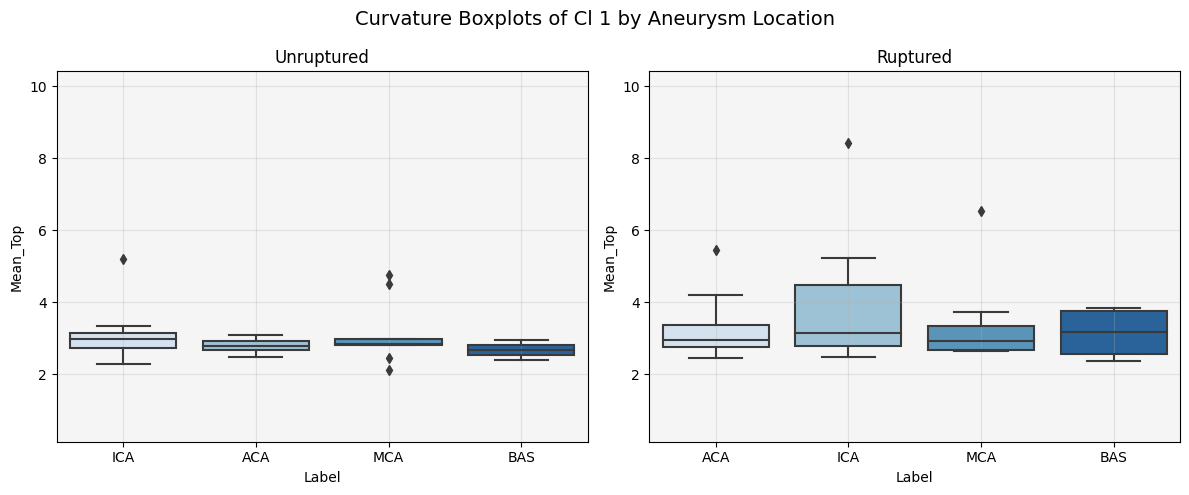

In [223]:
# CLUSTER 0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = cl0_SOM[cl0_SOM['ruptureStatus'] == 'U']

# make the plot
sns.boxplot(x='aneurysmLocation', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = cl0_SOM[cl0_SOM['ruptureStatus'] == 'R']

sns.boxplot(x='aneurysmLocation', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')
# axes[1].set_title('Curvature Boxplot of ICA by Aneurysm Location')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-2, y_max+2)

plt.suptitle('Curvature Boxplots of Cl 1 by Aneurysm Location', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

In cluser 0, the curvature seems to be not relevant as rupture cause.

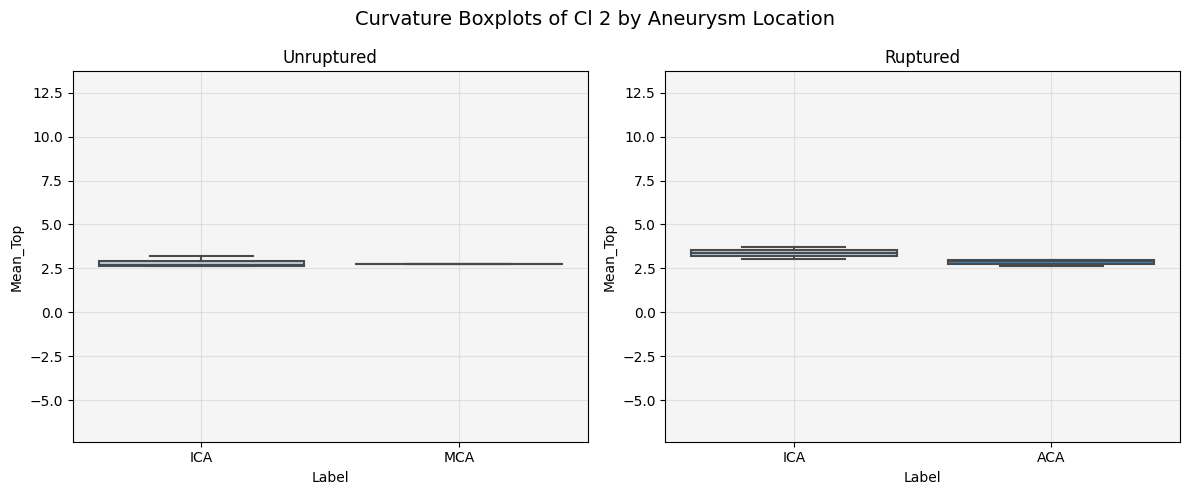

In [224]:
# CLUSTER 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = cl2_SOM[cl2_SOM['ruptureStatus'] == 'U']

sns.boxplot(x='aneurysmLocation', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = cl2_SOM[cl2_SOM['ruptureStatus'] == 'R']

sns.boxplot(x='aneurysmLocation', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-10, y_max+10)

plt.suptitle('Curvature Boxplots of Cl 2 by Aneurysm Location', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

Cluster 2 is really similar as distribution for ruptured and unruptured. Curvarture values are defined in a really close range of values.


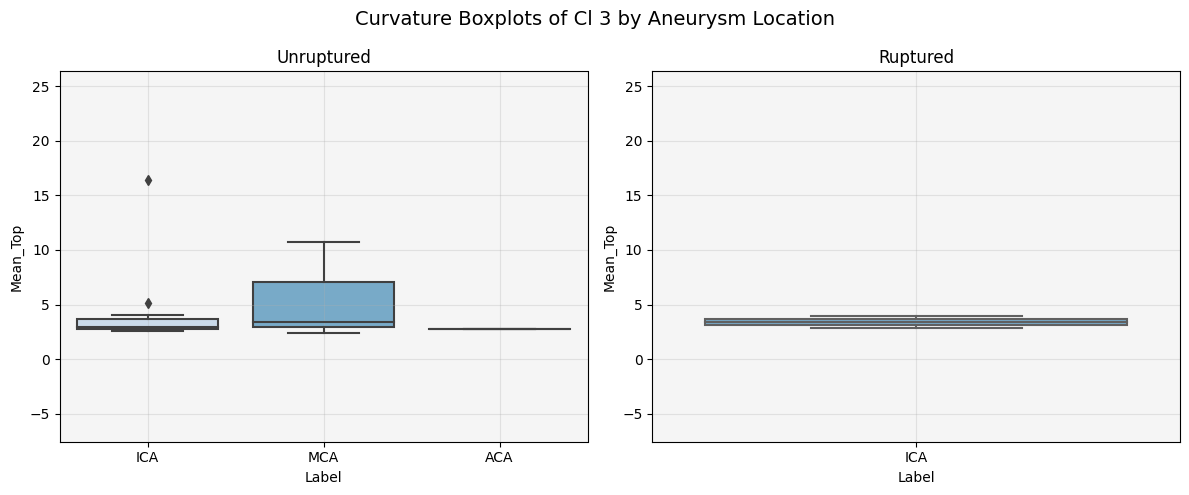

In [225]:
# CLUSTER 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = cl3_SOM[cl3_SOM['ruptureStatus'] == 'U']

sns.boxplot(x='aneurysmLocation', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = cl3_SOM[cl3_SOM['ruptureStatus'] == 'R']

sns.boxplot(x='aneurysmLocation', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-10, y_max+10)

plt.suptitle('Curvature Boxplots of Cl 3 by Aneurysm Location', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

Unruptured aneurysm for MCA present a really higher and wider distribution of curvature values.

Chek Aneurysm Location Curvature by clusters:

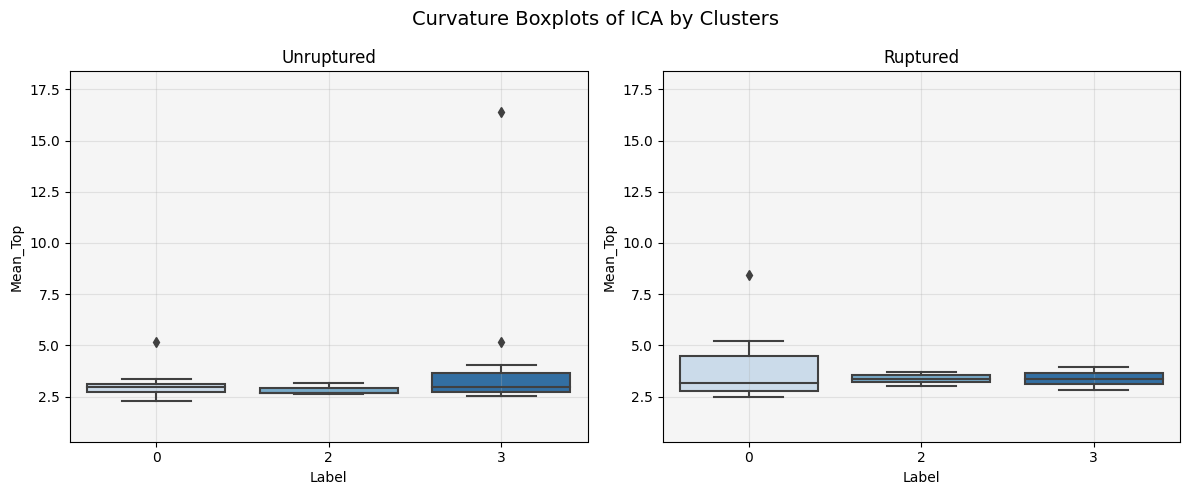

In [226]:
# ICA
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = final_SOM[(final_SOM['aneurysmLocation'] == 'ICA') & (final_SOM['ruptureStatus'] == 'U')]

sns.boxplot(x='Label', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = final_SOM[(final_SOM['aneurysmLocation'] == 'ICA') & (final_SOM['ruptureStatus'] == 'R')]

sns.boxplot(x='Label', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-2, y_max+2)

plt.suptitle('Curvature Boxplots of ICA by Clusters', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

Unless in cluster 3, where for unruptured elements there is a wider distibution and higher curvature values, in other clusters it is not possible to detect any curvature potential influence on rupture of aneurysms.

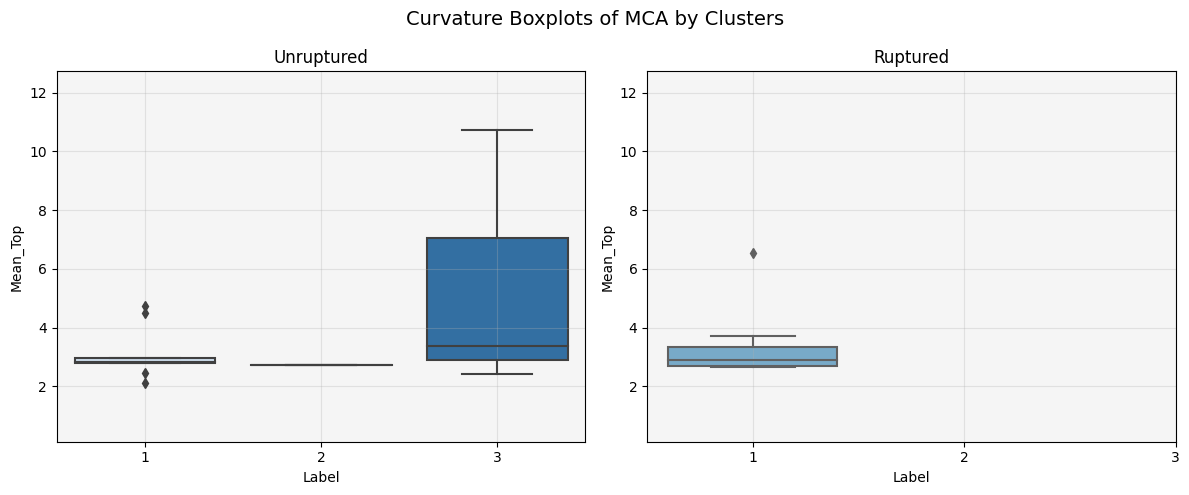

In [227]:
# MCA
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = final_SOM[(final_SOM['aneurysmLocation'] == 'MCA') & (final_SOM['ruptureStatus'] == 'U')]

sns.boxplot(x='Label', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')
axes[0].set_xticks([0, 1, 2], ['1', '2', '3'])

# ruptured
selectR = final_SOM[(final_SOM['aneurysmLocation'] == 'MCA') & (final_SOM['ruptureStatus'] == 'R')]

sns.boxplot(x='Label', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')
axes[1].set_xticks([0, 1, 2], ['1', '2', '3'])


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-2, y_max+2)

plt.suptitle('Curvature Boxplots of MCA by Clusters', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

In cluster 3 there are patients with aneurysm on MCA and curvature is much higher than in other clsuters. This is in line with previous studies. The same reasoning can not be done for cluster 1.

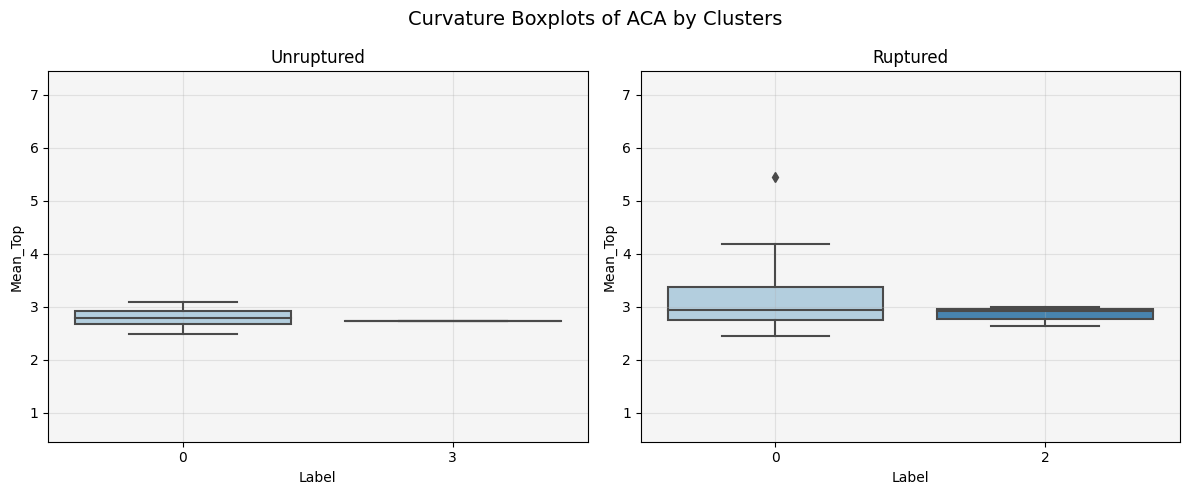

In [228]:
# ACA
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = final_SOM[(final_SOM['aneurysmLocation'] == 'ACA') & (final_SOM['ruptureStatus'] == 'U')]

sns.boxplot(x='Label', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = final_SOM[(final_SOM['aneurysmLocation'] == 'ACA') & (final_SOM['ruptureStatus'] == 'R')]

sns.boxplot(x='Label', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-2, y_max+2)

plt.suptitle('Curvature Boxplots of ACA by Clusters', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

In ACA, curvature seems to have no impact on rupture.

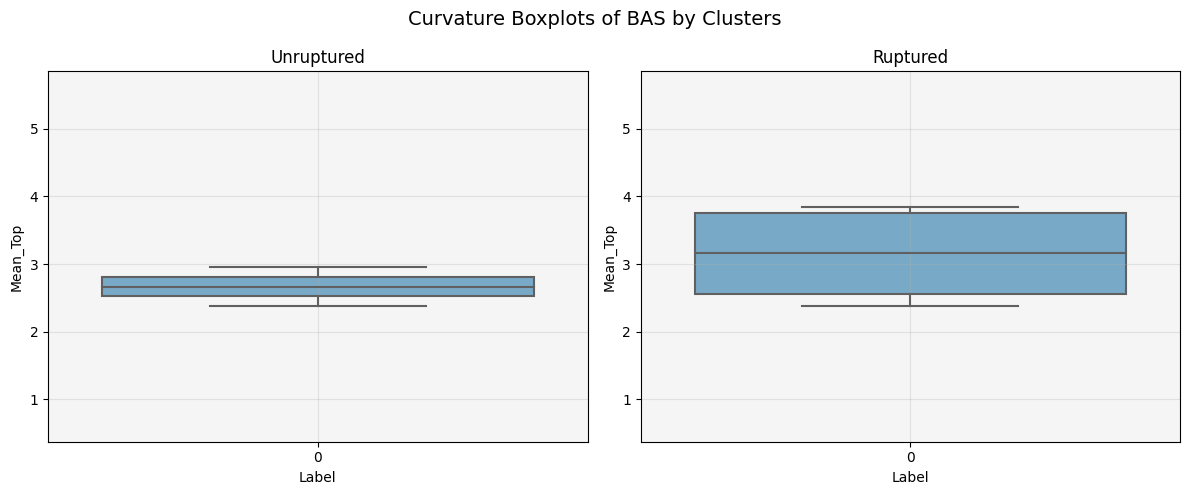

In [229]:
# BAS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = final_SOM[(final_SOM['aneurysmLocation'] == 'BAS') & (final_SOM['ruptureStatus'] == 'U')]

sns.boxplot(x='Label', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = final_SOM[(final_SOM['aneurysmLocation'] == 'BAS') & (final_SOM['ruptureStatus'] == 'R')]

sns.boxplot(x='Label', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-2, y_max+2)

plt.suptitle('Curvature Boxplots of BAS by Clusters', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

In BAS, as in ACA, there is no curvature impact on aneurysm rupture.

Curvature Box-Plot by Clusters:

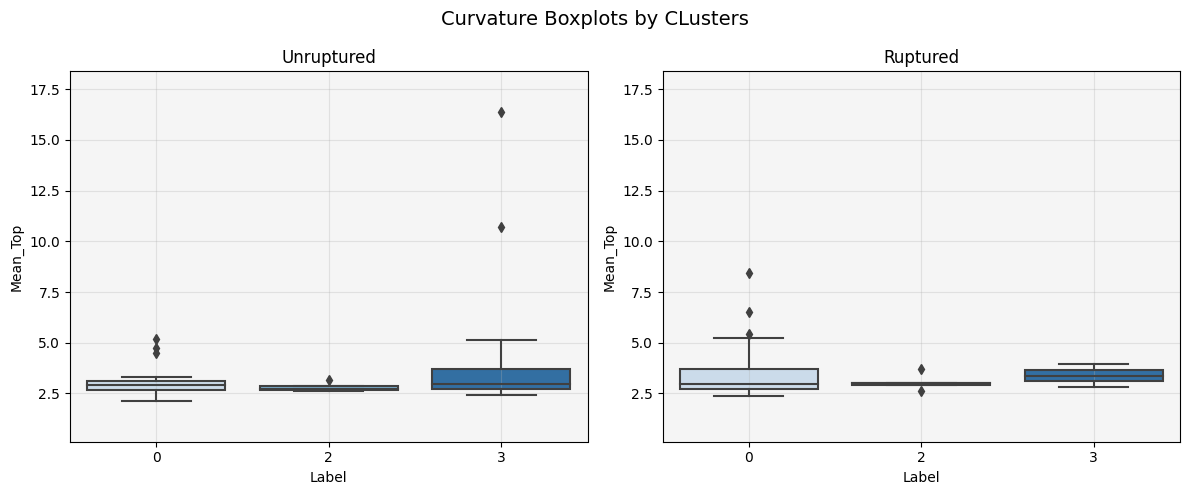

In [230]:
# CURVATURE PLOT BY CLUSTERS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# unruptured
selectU = final_SOM[final_SOM['ruptureStatus'] == 'U']

sns.boxplot(x='Label', y='Mean_Top', data=selectU, palette="Blues", ax=axes[0])
axes[0].set_title('Unruptured')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean_Top')
axes[0].grid(True, linestyle='-', alpha=0.3)
axes[0].set_facecolor('whitesmoke')

# ruptured
selectR = final_SOM[final_SOM['ruptureStatus'] == 'R']

sns.boxplot(x='Label', y='Mean_Top', data=selectR, palette="Blues", ax=axes[1])
axes[1].set_title('Ruptured')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Mean_Top')
axes[1].grid(True, linestyle='-', alpha=0.3)
axes[1].set_facecolor('whitesmoke')


y_max = max(selectU['Mean_Top'].max(), selectR['Mean_Top'].max())
y_min = min(selectU['Mean_Top'].min(), selectR['Mean_Top'].min())
for ax in axes:
    ax.set_ylim(y_min-2, y_max+2)

plt.suptitle('Curvature Boxplots by CLusters', fontsize=14)
plt.tight_layout()
plt.show()

**Comment**:

The only cluster which presents differences in line with previous works on curvature is cluster 3. It is possible to assume that the only patient who presented a curvature influence are in cluster 3.

Rupture Status by Aneurysm Location in Cluster 3:

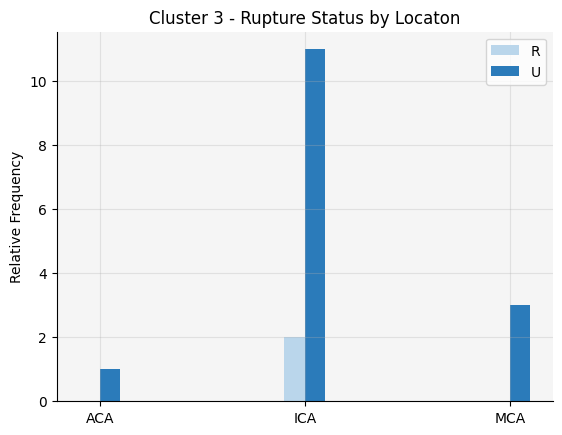

In [231]:
# RUPTURE STATUS BY ANEURYSM LOCATION IN CLUSTER 3

# select data
data = pd.crosstab(cl3_SOM['ruptureStatus'], cl3_SOM['aneurysmLocation'])

# select aneurysm locations categories
types = ("ACA", "ICA", "MCA")
# create dictionary of ruptured and unruptured values
values = {'R': data.values[0].tolist(),
          'U': data.values[1].tolist()}

x = np.arange(len(types))  # the label oflocations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()

ruptured_color = sns.color_palette("Blues")[1]
unruptured_color = sns.color_palette("Blues")[4]

# plot the bars for ruptured
ax.bar(x - width/2, values['R'], width, label='R', color=ruptured_color)

# plot the bars for unruptured
ax.bar(x + width/2, values['U'], width, label='U', color=unruptured_color)

ax.set_ylabel('Relative Frequency')
ax.set_title('Cluster 3 - Rupture Status by Locaton')
ax.set_xticks(x)
ax.set_xticklabels(types)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
ax.legend()

plt.show()

**Comment**:

In cluster 3 most of patients present an aneurysm on the ICA. All patients with aneurysm on MCA, which, from graphs shown before, are the patients, within the groups of patients with aneurysm on MCA, which show the highest curvature values, have unruptured aneurysms.

Check distribution of aneurysm locations between clusters:

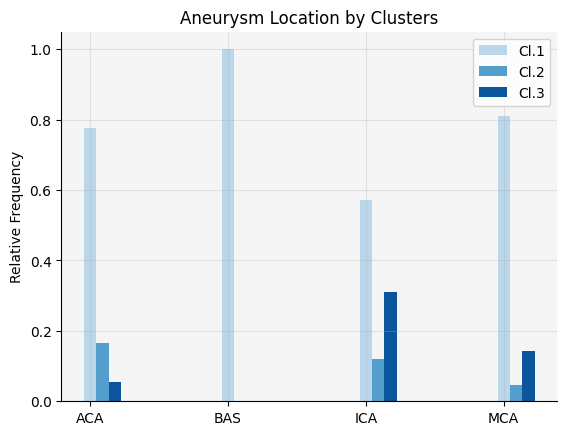

In [232]:
# select data
data = pd.crosstab(final_SOM['Label'], final_SOM['aneurysmLocation'])

# create categories for aneurysm locations
types = ("ACA", "BAS", "ICA", "MCA")
# create dictionary for clusters values
values = {'Cl.0': data.values[0].tolist()/data.values.sum(axis = 0),
          'Cl.2': data.values[1].tolist()/data.values.sum(axis = 0),
          'Cl.3': data.values[2].tolist()/data.values.sum(axis = 0)}

x = np.arange(len(types))  # the label of locations
width = 0.09  # the width of the bars

fig, ax = plt.subplots()

# create color palettes
cl0_color = sns.color_palette("Blues")[1]
cl2_color = sns.color_palette("Blues")[3]
cl3_color = sns.color_palette("Blues")[5]

# plot the bars for cluster 0
ax.bar(x, values['Cl.0'], width, label='Cl.1', color=cl0_color)

# plot the bars for cluster 2
ax.bar(x + width, values['Cl.2'], width, label='Cl.2', color=cl2_color)

# plot the bars for cluster 3
ax.bar(x + 2*width, values['Cl.3'], width, label='Cl.3', color=cl3_color)


ax.set_ylabel('Relative Frequency')
ax.set_title('Aneurysm Location by Clusters')
ax.set_xticks(x)
ax.set_xticklabels(types)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
ax.legend()

plt.show()

**Comment**:

Looking at this graph, considering the preliminary analysis where ACA and BAS presented the highest number of ruptured aneurysms and observing graphs made before, we can presume that location of aneurysm plays a pivotal role in rupture. Curvature would be a second factor, associated to other possible influencing variables.

# PCA on curvature


Given that curvature results as no different between clusters, but the values taken were mean and maximum which lead to a loss of information considering a curvature vector of 1625 elements, try to consider Principal Component Analysis. With this technique we should be able to state with more accuracy if curvatures can be considered different or not.

In [233]:
# import libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [234]:
# vertical stack to obtain vertical vectors
curv_pca = np.vstack(c['Curvature'].values).T

In [235]:
curv_pca.shape

(1623, 543)

In [236]:
# scale arrays
scaler = StandardScaler()
curv_scaled = scaler.fit_transform(curv_pca)

In [237]:
# fit PCA
pca = PCA(n_components=10)
pca.fit_transform(curv_scaled)

array([[-15.7520171 ,  -5.49938925,   3.07287335, ...,  -0.79005714,
         -1.44967941,  -0.16337905],
       [-15.7520487 ,  -5.50103783,   3.07321008, ...,  -0.79390211,
         -1.45078245,  -0.1747637 ],
       [-15.75194679,  -5.49572107,   3.07212412, ...,  -0.78150192,
         -1.44722508,  -0.1380477 ],
       ...,
       [-15.75123053,  -5.45835388,   3.06449177, ...,  -0.69435114,
         -1.42222327,   0.11999916],
       [-15.75119925,  -5.45672212,   3.06415848, ...,  -0.69054542,
         -1.42113148,   0.13126762],
       [-15.75112817,  -5.45301413,   3.06340111, ...,  -0.68189735,
         -1.41865052,   0.1568739 ]])

In [238]:
print(pca.explained_variance_ratio_) # the only observable value is the first one. Try maintaining only it.

[0.28234495 0.07827478 0.03775373 0.02460714 0.01508411 0.01265851
 0.01084006 0.00844219 0.00683896 0.00591157]


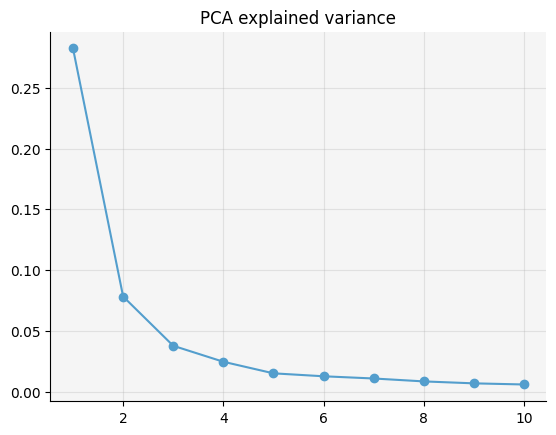

In [239]:
# Variance explained plot
color = sns.color_palette("Blues")[3]
plt.plot(np.arange(1, 11), pca.explained_variance_ratio_, '-o', color = color)
plt.title('PCA explained variance')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')

**Comment**:

There is an important drop from first to second PC. However, the elbow could be detected at number of PCs equals to 3. However, considering the explained variance and our purpose, we decide to take only the first PC value.

Consider only 1 PC:

In [240]:
# perform PC
pca = PCA(n_components=1)
pca.fit_transform(curv_scaled)

array([[-15.7520171 ],
       [-15.7520487 ],
       [-15.75194679],
       ...,
       [-15.75123053],
       [-15.75119925],
       [-15.75112817]])

In [241]:
# curvature PCA components
curv_pca = pca.components_.flatten().tolist()
len(curv_pca)

543

In [242]:
# assocaite first PC to dataframe column
c['Curv_PCA'] = curv_pca

In [243]:
# create a new dataframe with each patient and the maxium and the mean curvature value
pca_list = []

for i in df['id'].unique():
    # select the ith patient
    select = c[c.ID_patient == i]
    # compute the maximum curvature within the centerlines
    pca_curv = select['Curv_PCA'].max()

    pca_list.append(pca_curv)

# create the final new dataframe
df['Curv_PCA'] = pca_list
df

,index,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory,Max_Curvature,Mean_Curvature,Curvature,Mean_Top,Max_Top,Radius,Curv_PCA
id,,,,,,,,,,,,,,,,,,
C0001,0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN,5.206714,3.790571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.669099,3.110733,2.092899,0.053022
C0002,1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN,12.177532,6.175527,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.005631,3.677076,2.629028,0.054165
C0003,2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN,5.458297,3.518064,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.307260,2.960496,1.922469,0.060925
C0004,3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN,9.362738,4.881177,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.887047,3.691017,1.915786,0.054310
C0005,4,C0005,NiguardaHospitalMilan,3D-RA,26,F,LAT,ICA,R,False,NaN,104.308758,18.477107,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.955328,12.517609,2.024848,0.050186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0094,89,C0094,NiguardaHospitalMilan,3D-RA,36,F,TER,MCA,R,False,NaN,7.165963,5.126103,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.980576,3.539340,1.745505,0.048660
C0096,91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN,56.842698,16.939858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.849335,8.251069,1.983498,0.028587
C0097,92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN,3.535010,3.008104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.478698,3.016430,2.451018,0.056831


In [244]:
# append values in final_SOM dataframe
to_add = []
for i in final_SOM['id'].unique():
  if i in df['id'].unique():

    to_add.append(float(df[df.id == i]['Curv_PCA'].values))

In [245]:
# add the column
final_SOM['Curv_PCA'] = to_add

### Cluster Analysis


Perform again the Analysis:

In [246]:
# create the clusters again
cl0_SOM = final_SOM[final_SOM.Label == 0]
cl1_SOM = final_SOM[final_SOM.Label == 1]
cl2_SOM = final_SOM[final_SOM.Label == 2]
cl3_SOM = final_SOM[final_SOM.Label == 3]

In [247]:
# make curvature pca comparisons - even if they are practically impossible to be interpreted

# mean of maximum
mean_max0 = cl0_SOM['Curv_PCA'].mean()
mean_max1 = cl1_SOM['Curv_PCA'].mean()
mean_max2 = cl2_SOM['Curv_PCA'].mean()
mean_max3 = cl3_SOM['Curv_PCA'].mean()

# maximum of maximum
max_max0 = cl0_SOM['Curv_PCA'].max()
max_max1 = cl1_SOM['Curv_PCA'].max()
max_max2 = cl2_SOM['Curv_PCA'].max()
max_max3 = cl3_SOM['Curv_PCA'].max()

pd.DataFrame({'Cluster 0': [mean_max0, max_max0],

              'Cluster 1': [mean_max1, max_max1],

              'Cluster 2': [mean_max2, max_max2],

              'Cluster 3': [mean_max3, max_max3]},

              index = ['Mean of Maximum - pca', 'Max of Maximum - pca'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Mean of Maximum - pca,0.052837,NaN,0.050860,0.043674
Max of Maximum - pca,0.060925,NaN,0.056098,0.054266


Plot Curvature PCA Box-Plot:

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status')

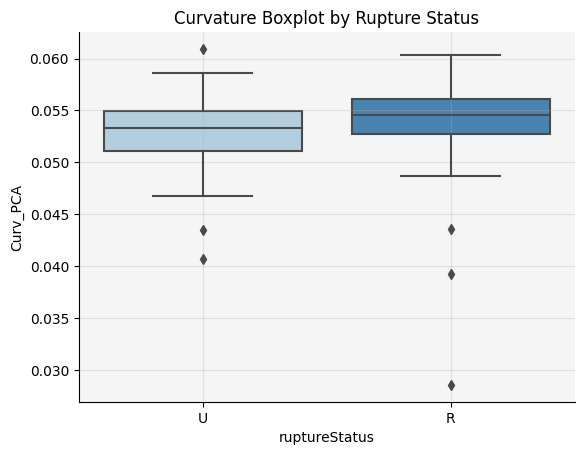

In [248]:
data = cl0_SOM[['Curv_PCA', 'ruptureStatus']]
sns.boxplot(x='ruptureStatus', y='Curv_PCA', data=data, palette="Blues")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status')

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status')

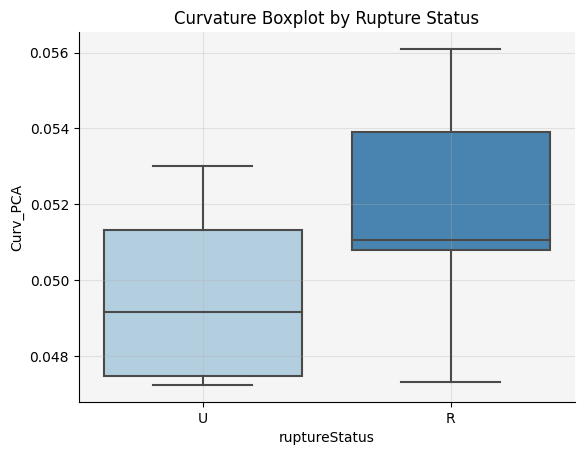

In [249]:
data = cl2_SOM[['Curv_PCA', 'ruptureStatus']]
sns.boxplot(x='ruptureStatus', y='Curv_PCA', data=data, palette="Blues")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status')

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status')

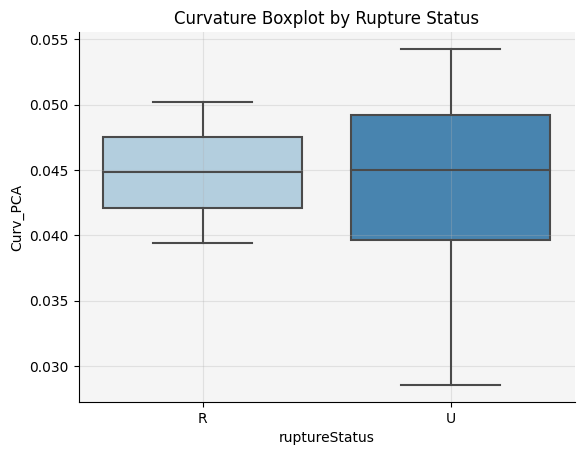

In [250]:
data = cl3_SOM[['Curv_PCA', 'ruptureStatus']]
sns.boxplot(x='ruptureStatus', y='Curv_PCA', data=data, palette="Blues")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status')

**Comment**:

Only cluster 3 presents a wider and higher range for unruptured elements. However, it is quite hard to interpretate this values.

Check ANOVA Assumptions:

In [251]:
# check normality
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM['Curv_PCA']),
      '\ncl2: ', scipy.stats.shapiro(cl2_SOM['Curv_PCA']),
      '\ncl3: ', scipy.stats.shapiro(cl3_SOM['Curv_PCA']))

# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):',
      '\ncl0: ', cl0_SOM['Curv_PCA'].std(),
      '\ncl2: ', cl2_SOM['Curv_PCA'].std(),
      '\ncl3: ', cl3_SOM['Curv_PCA'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.8166128396987915, pvalue=3.0244055437833595e-07) 
cl2:  ShapiroResult(statistic=0.9187818765640259, pvalue=0.3822507858276367) 
cl3:  ShapiroResult(statistic=0.9181143045425415, pvalue=0.13721497356891632)


Homogeneity of Variance (std): 
cl0:  0.005266223676069727 
cl2:  0.0031227650898553332 
cl3:  0.0075910875947633304


ANOVA assumptions could be considered as respected. Check if the difference can be considered as statistically significant with both ANOVA and Kruskal-Wallis H-test.

ANOVA:

In [252]:
# apply ANOVA
f_oneway(cl0_SOM['Curv_PCA'], cl2_SOM['Curv_PCA'], cl3_SOM['Curv_PCA'])

F_onewayResult(statistic=17.598269465092706, pvalue=4.1367275567238837e-07)

Kruskal-Wallis H-test:

In [253]:
scipy.stats.kruskal(cl0_SOM['Curv_PCA'],  cl2_SOM['Curv_PCA'],  cl3_SOM['Curv_PCA'])#, cl3_SOM['Max_Curvature'])

KruskalResult(statistic=26.221253871471674, pvalue=2.0236111678599125e-06)

Both results sugger a statistical difference in means and distribution between clsuters.

# Remove Cluster 3 obs and fit again SOM

We noticed in previous analysis that cluster 3 presented some evidence of the geometry impact, while cluster 1 and 2 no.
To understand better cluster 0 and 2, try to remove cluster 3 and repreat the analysis.

### Create the dataset

In [254]:
# upload padded spline dataframe
spline_pad = pd.read_feather("/content/drive/MyDrive/THESIS/pad_spline.feather")
spline_pad.index = spline_pad['ID_patient']
spline_pad = spline_pad.drop(['ID_patient'], axis = 1)
spline_pad

,ID_centerline,Xspline,Yspline,Zspline,s,Radius
ID_patient,,,,,,
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
...,...,...,...,...,...,...
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631


In [255]:
# drop values associated to cluster 3
spline_reduced = spline_pad.drop(cl3_SOM['id'].values.tolist(), axis = 0)

In [256]:
# see the dataset
spline_reduced

,ID_centerline,Xspline,Yspline,Zspline,s,Radius
ID_patient,,,,,,
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
C0001,0,62.751904,3.530136,63.179012,0.000000,1.862776
...,...,...,...,...,...,...
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631
C0099,6,44.896629,31.252348,26.987686,90.122096,0.408631


In [257]:
# create the reduced dataframe

# avoid warnings
warnings.filterwarnings("ignore")

ids = spline_reduced.index.unique()
sp_df_reduced = pd.DataFrame(columns = ['ID_patient', 'ID_centerline', 'Xspline', 'Yspline', 'Zspline', 's', 'Radius'])

for i in range(len(ids)):
    select = spline_reduced.loc[ids[i], ['ID_centerline', 'Xspline', 'Yspline', 'Zspline', 's', 'Radius']]
    max_cent = select['ID_centerline'].max()

    for j in range(max_cent+1):
        # create the arrays from the elements of sp_df dataframe for each rows
        x = np.array(select[select.ID_centerline == j]['Xspline'])
        y = np.array(select[select.ID_centerline == j]['Yspline'])
        z = np.array(select[select.ID_centerline == j]['Zspline'])
        s = np.array(select[select.ID_centerline == j]['s'])
        r = np.array(select[select.ID_centerline == j]['Radius'])

        sp_df_reduced = sp_df_reduced.append(pd.DataFrame({'ID_patient': ids[i],
                                            'ID_centerline': j,
                                            'Xspline': [x],
                                            'Yspline': [y],
                                            'Zspline': [z],
                                            's': [s],
                                            'Radius': [r]}))

sp_df_reduced.index = sp_df_reduced['ID_patient']
sp_df_reduced = sp_df_reduced.drop('ID_patient', axis = 1)

### Fit the SOM

In [258]:
# look at the dataframe
sp_df_reduced

,ID_centerline,Xspline,Yspline,Zspline,s,Radius
ID_patient,,,,,,
C0001,0,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,1,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858395, 63.17901229858395, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,2,"[62.75190353393553, 62.75190353393553, 62.7519...","[3.5301361083984384, 3.5301361083984384, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,3,"[62.75190353393554, 62.75190353393554, 62.7519...","[3.530136108398436, 3.530136108398436, 3.53013...","[63.179012298583984, 63.179012298583984, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
C0001,4,"[62.751903533935476, 62.751903533935476, 62.75...","[3.5301361083984344, 3.5301361083984344, 3.530...","[63.179012298583935, 63.179012298583935, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277..."
...,...,...,...,...,...,...
C0099,2,"[19.37309837341308, 19.37309837341308, 19.3730...","[7.750606060028071, 7.750606060028071, 7.75060...","[51.512187957763636, 51.512187957763636, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612..."
C0099,3,"[19.37309837341309, 19.37309837341309, 19.3730...","[7.750606060028078, 7.750606060028078, 7.75060...","[51.512187957763665, 51.512187957763665, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612..."
C0099,4,"[19.373098373413104, 19.373098373413104, 19.37...","[7.750606060028083, 7.750606060028083, 7.75060...","[51.5121879577637, 51.5121879577637, 51.512187...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612..."


In [259]:
# Create an array containing all the X, Y, Z, s vector values
arr_temp = sp_df_reduced.iloc[:, 1:5].to_numpy()

In [260]:
# modify the array format to get the correct one for SOM algorithm
list_arr = []
for i in range(len(arr_temp)):
  list_arr.append(np.concatenate(arr_temp[i]))

In [261]:
# conver the list into the array and check it
arr = np.array(list_arr)
arr

array([[ 62.75190353,  62.75190353,  62.75190353, ...,  86.41523542,
         86.41523542,  86.41523542],
       [ 62.75190353,  62.75190353,  62.75190353, ...,  86.89853841,
         86.89853841,  86.89853841],
       [ 62.75190353,  62.75190353,  62.75190353, ..., 102.71065966,
        102.71065966, 102.71065966],
       ...,
       [ 19.37309837,  19.37309837,  19.37309837, ...,  94.31348145,
         94.31348145,  94.31348145],
       [ 19.37309837,  19.37309837,  19.37309837, ...,  96.66318733,
         96.66318733,  96.66318733],
       [ 19.37309837,  19.37309837,  19.37309837, ...,  90.12209636,
         90.12209636,  90.12209636]])

In [262]:
# check the shape
arr.shape

(445, 6500)

In [263]:
# fit the scaler
scaler = RobustScaler()
arr = scaler.fit_transform(arr)

In [264]:
# fit the SOM grid
spline_som = SOM(m = 2, n = 1, dim=6500, random_state = 1234, lr = 0.7, max_iter = 20000)
spline_som.fit(arr)

In [265]:
# predict labels
predictions = spline_som.predict(arr)

In [266]:
sp_df_reduced['Label'] = predictions

In [267]:
ids = sp_df_reduced.index.unique()
final_label = []
review = []
to_drop = []
for i in ids:
    # select ith patient
    select = sp_df_reduced[sp_df_reduced.index == i]
    # create a list with the associated label's centerlines
    cent_list = select['Label'].tolist()
    # count all the occurences of the labels
    occurences = dict([(k, cent_list.count(k)) for k in cent_list])
    # determine the label which is mostly present for that patient
    max_value = max(occurences.values())
    # return the keys associated to the maximum value
    max_keys = [key for key, value in occurences.items() if value == max_value]

    # if the maximum in unique, append it to the final list
    if len(max_keys) == 1:
        final_label.append(max_keys)

    # else, raise an error
    else:
        review.append(occurences)
        to_drop.append(i)
        print(f'For patient {i} there is not a unique associated label.')

For patient C0092 there is not a unique associated label.


In [268]:
# see reviews
review

[{1: 2, 0: 2}]

In [269]:
# drop the patients before
sp_df_reduced = sp_df_reduced.drop(to_drop, axis = 0)
sp_df_reduced

,ID_centerline,Xspline,Yspline,Zspline,s,Radius,Label
ID_patient,,,,,,,
C0001,0,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",0
C0001,1,"[62.75190353393551, 62.75190353393551, 62.7519...","[3.5301361083984353, 3.5301361083984353, 3.530...","[63.17901229858395, 63.17901229858395, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",0
C0001,2,"[62.75190353393553, 62.75190353393553, 62.7519...","[3.5301361083984384, 3.5301361083984384, 3.530...","[63.17901229858397, 63.17901229858397, 63.1790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",0
C0001,3,"[62.75190353393554, 62.75190353393554, 62.7519...","[3.530136108398436, 3.530136108398436, 3.53013...","[63.179012298583984, 63.179012298583984, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",0
C0001,4,"[62.751903533935476, 62.751903533935476, 62.75...","[3.5301361083984344, 3.5301361083984344, 3.530...","[63.179012298583935, 63.179012298583935, 63.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862775948324005, 1.862775948324005, 1.86277...",0
...,...,...,...,...,...,...,...
C0099,2,"[19.37309837341308, 19.37309837341308, 19.3730...","[7.750606060028071, 7.750606060028071, 7.75060...","[51.512187957763636, 51.512187957763636, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612...",1
C0099,3,"[19.37309837341309, 19.37309837341309, 19.3730...","[7.750606060028078, 7.750606060028078, 7.75060...","[51.512187957763665, 51.512187957763665, 51.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612...",0
C0099,4,"[19.373098373413104, 19.373098373413104, 19.37...","[7.750606060028083, 7.750606060028083, 7.75060...","[51.5121879577637, 51.5121879577637, 51.512187...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6126974774985663, 1.6126974774985663, 1.612...",1


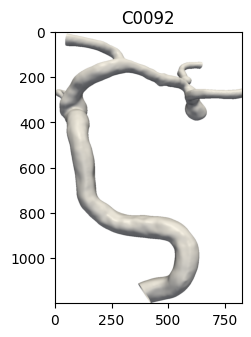

In [270]:
# see graphically the dropped patients
plt.figure(figsize=(12,12))
img = os.listdir(images_path)
to_plot = to_drop
for i in range(len(to_plot)):
    random_image = load_img(images_path + to_plot[i] + '.png')
    plt.subplot(331 + i)
    plt.title(to_plot[i])
    plt.imshow(random_image)
plt.show()

In [271]:
# associate 1 label to each patient
SOM_df2 = pd.DataFrame({'ID_patient': sp_df_reduced.index.unique(),
                       'Label': np.array(final_label).flatten()})
SOM_df2

,ID_patient,Label
0,C0001,0
1,C0002,0
2,C0003,1
3,C0004,0
4,C0008,0
...,...,...
71,C0094,1
72,C0096,1
73,C0097,1
74,C0098,1


In [272]:
# create the final REDUCED dataframe for the SOM algorithm

# create an empty list
to_drop = []
for i in df['id'].tolist():
    # if the index in final_data is not present in final_1, drop it
    if i not in SOM_df2['ID_patient'].tolist():
        to_drop.append(i)

# drop the selected ids
df.index = df['id']
final_SOM2 = df.drop(to_drop, axis = 0)
# associate the cluster label
final_SOM2['Label'] = np.array(final_label).flatten()
final_SOM2 = final_SOM2.reset_index(drop = True)
final_SOM2

,index,id,institution,modality,age,sex,aneurysmType,aneurysmLocation,ruptureStatus,multipleAneurysms,medicalIstory,Max_Curvature,Mean_Curvature,Curvature,Mean_Top,Max_Top,Radius,Curv_PCA,Label
0,0,C0001,NiguardaHospitalMilan,3D-RA,53,F,LAT,ICA,U,False,NaN,5.206714,3.790571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.669099,3.110733,2.092899,0.053022,0
1,1,C0002,NiguardaHospitalMilan,3D-RA,35,F,LAT,ICA,U,False,NaN,12.177532,6.175527,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.005631,3.677076,2.629028,0.054165,0
2,2,C0003,NiguardaHospitalMilan,3D-RA,43,F,TER,ICA,U,False,NaN,5.458297,3.518064,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.307260,2.960496,1.922469,0.060925,1
3,3,C0004,NiguardaHospitalMilan,3D-RA,60,F,TER,ICA,U,True,NaN,9.362738,4.881177,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.887047,3.691017,1.915786,0.054310,0
4,7,C0008,NiguardaHospitalMilan,3D-RA,68,M,TER,ACA,R,False,NaN,73.082481,18.209056,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.269953,9.584491,2.645132,0.048387,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,89,C0094,NiguardaHospitalMilan,3D-RA,36,F,TER,MCA,R,False,NaN,7.165963,5.126103,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.980576,3.539340,1.745505,0.048660,1
72,91,C0096,NiguardaHospitalMilan,3D-RA,67,M,TER,BAS,R,False,NaN,56.842698,16.939858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.849335,8.251069,1.983498,0.028587,1
73,92,C0097,NiguardaHospitalMilan,3D-RA,84,F,LAT,ICA,R,False,NaN,3.535010,3.008104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.478698,3.016430,2.451018,0.056831,1
74,93,C0098,NiguardaHospitalMilan,3D-RA,59,F,TER,MCA,R,False,NaN,11.901422,5.985927,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.211976,4.356096,2.634574,0.058740,1


### Analyze Clusters

In [273]:
# create the clusters
cl0_SOM2 = final_SOM2[final_SOM2.Label == 0]
cl1_SOM2 = final_SOM2[final_SOM2.Label == 1]
cl2_SOM2 = final_SOM2[final_SOM2.Label == 2]

**Proportion:**

In [274]:
pd.DataFrame({'Cluster 0': [cl0_SOM2.shape[0], cl0_SOM2.shape[0]/final_SOM2.shape[0]],

              'Cluster 1': [cl1_SOM2.shape[0], cl1_SOM2.shape[0]/final_SOM2.shape[0]],

             'Cluster 2': [cl2_SOM2.shape[0], cl2_SOM2.shape[0]/final_SOM2.shape[0]]},

              index = ['Number', 'Proportion'])

,Cluster 0,Cluster 1,Cluster 2
Number,32.000000,44.000000,0.0
Proportion,0.421053,0.578947,0.0


SOM Algorithm suggests only 2 clusters.

**Age:**

In [275]:
# AGE

#### compute the mean age for each cluster
mean_cl0 = cl0_SOM2['age'].mean()
mean_cl1 = cl1_SOM2['age'].mean()

# overall mean
overall_mean = final_SOM2['age'].mean()

#### comput the mode age for each cluster
mode_cl0 = cl0_SOM2['age'].mode().to_list()
mode_cl1 = cl1_SOM2['age'].mode().to_list()

# ovarall mode
overall_mode = final_SOM2['age'].mode().to_list()

pd.DataFrame({'Cluster 0': [f'{mean_cl0:.4}', mode_cl0],

              'Cluster 1': [f'{mean_cl1:.4}', mode_cl1],

              'Overall': [f'{overall_mean:.4}', overall_mode]},

              index = ['Mean', 'Mode'])

,Cluster 0,Cluster 1,Overall
Mean,53.88,53.8,53.83
Mode,"[68, 74]","[43, 49, 51, 59, 74]",[74]


ANOVA - Age:

In [276]:
# option 1
# check normality
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM2['age']),
      '\ncl1: ', scipy.stats.shapiro(cl1_SOM2['age']))


# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):\n'
      'cl0: ', cl0_SOM2['age'].std(),
      '\ncl1: ', cl1_SOM2['age'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.9391917586326599, pvalue=0.07101801037788391) 
cl1:  ShapiroResult(statistic=0.9912124872207642, pvalue=0.9813272356987)


Homogeneity of Variance (std):
cl0:  12.96832369101106 
cl1:  13.391388321751123


In [277]:
f_oneway(cl0_SOM2['age'], cl1_SOM2['age'])

F_onewayResult(statistic=0.0006711698225314819, pvalue=0.9794012972445472)

**Comment**:

Age results not statistically different between clusters.

**Gender:**

In [278]:
# MALE AND FEMALE

tot_f = final_SOM2.groupby('sex')['sex'].count()[0]
tot_m = final_SOM2.groupby('sex')['sex'].count()[1]

nf_0 = cl0_SOM2.groupby('sex')['sex'].count()[0]
nf_1 = cl1_SOM2.groupby('sex')['sex'].count()[0]

nm_0 = cl0_SOM2.groupby('sex')['sex'].count()[1]
nm_1 = cl1_SOM2.groupby('sex')['sex'].count()[1]


pd.DataFrame({'Cluster 0': [nf_0, f'{(nf_0/tot_f)*100:.2f}%', nm_0, f'{(nm_0/tot_m)*100:.2f}%'],

              'Cluster 1': [nf_1, f'{(nf_1/tot_f)*100:.2f}%', nm_1, f'{(nm_1/tot_m)*100:.2f}%']},

             index = ['F', 'F proportion ', 'M', 'M proportion'])

,Cluster 0,Cluster 1
F,21,25
F proportion,45.65%,54.35%
M,11,19
M proportion,36.67%,63.33%


X-Square Test:

In [279]:
# create the contingency table
contingency_table = pd.crosstab(final_SOM2['Label'], final_SOM2['sex'])
# perform the test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(p_value, chi2)

0.5906778702586538 0.28928689064558644


**Comment**:

Sex and clsuters' label result not statistically related, they are independent.

**Curvature:**

In [280]:
# Check Curvature

# mean of maximum
max_mean0 = cl0_SOM2['Max_Curvature'].mean()
max_mean1 = cl1_SOM2['Max_Curvature'].mean()

# mean of mean
mean_mean0 = cl0_SOM2['Mean_Curvature'].mean()
mean_mean1 = cl1_SOM2['Mean_Curvature'].mean()

# maximum of maximum
max_max0 = cl0_SOM2['Max_Curvature'].max()
max_max1 = cl1_SOM2['Max_Curvature'].max()

pd.DataFrame({'Cluster 0': [max_mean0, mean_mean0, max_max0],

              'Cluster 1': [max_mean1, mean_mean1, max_max1],},

              index = ['Mean of Maximum', 'Mean of Mean', 'Max of Maximum'])

,Cluster 0,Cluster 1
Mean of Maximum,42.774868,60.875702
Mean of Mean,10.222422,15.820205
Max of Maximum,536.275640,1374.758311


Remove the patient with the extreme curvature value -> C0009 \\
And check how curvature will be modified.


In [281]:
# recompute the values
cl1_SOM2[cl1_SOM2.id != 'C0009']['Max_Curvature'].mean()

30.32029219556684

In [282]:
# recompute the values
cl1_SOM2[cl1_SOM2.id != 'C0009']['Max_Curvature'].max()

232.56929155236043

In [283]:
# recompute the values
cl1_SOM2[cl1_SOM2.id != 'C0009']['Mean_Curvature'].mean()

9.67329538300409

Check ANOVA assumptions:

In [284]:
# check normality
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM2['Max_Curvature']),
      '\ncl1: ', scipy.stats.shapiro(cl1_SOM2['Max_Curvature']))

# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):',
      '\ncl0: ', cl0_SOM2['Max_Curvature'].std(),
      '\ncl1: ', cl1_SOM2['Max_Curvature'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.4270934462547302, pvalue=4.5431919337701743e-10) 
cl1:  ShapiroResult(statistic=0.26331961154937744, pvalue=1.5305423215709185e-13)


Homogeneity of Variance (std): 
cl0:  100.67503871757609 
cl1:  208.20522268290284


Kruskal-Wallis H-test:

In [285]:
scipy.stats.kruskal(cl0_SOM2['Max_Curvature'], cl1_SOM2['Max_Curvature'])

KruskalResult(statistic=0.8571428571428612, pvalue=0.35453947977349987)

In [286]:
scipy.stats.kruskal(cl0_SOM2['Mean_Curvature'], cl1_SOM2['Mean_Curvature'])

KruskalResult(statistic=0.2767119244391836, pvalue=0.5988644813909886)

With Kruskal-Wallis H-test we can state that curvature data can come from the same distribution without differences.

**Rupture Status:**

In [287]:
# rupture status

# compute the total number of patients according to the status of the aneurysm
tot_R = final_SOM2.groupby('ruptureStatus')['ruptureStatus'].count()[0]
tot_U = final_SOM2.groupby('ruptureStatus')['ruptureStatus'].count()[1]

# counts the rupture status' number of patients for each cluster
R_0 = cl0_SOM2.groupby('ruptureStatus')['ruptureStatus'].count()[0]
U_0 = cl0_SOM2.groupby('ruptureStatus')['ruptureStatus'].count()[1]

R_1 = cl1_SOM2.groupby('ruptureStatus')['ruptureStatus'].count()[0]
U_1 = cl1_SOM2.groupby('ruptureStatus')['ruptureStatus'].count()[1]


pd.DataFrame({'Cluster 0': [R_0, f'{(R_0/tot_R)*100:.2f}%',
                                U_0, f'{(U_0/tot_U)*100:.2f}%'],

              'Cluster 1': [R_1, f'{(R_1/tot_R)*100:.2f}%',
                                 U_1, f'{(U_1/tot_U)*100:.2f}%']},

             index = ['Ruptured', 'Ruptured proportion', 'Unruptured', 'Unruptured proportion'])

,Cluster 0,Cluster 1
Ruptured,17,22
Ruptured proportion,43.59%,56.41%
Unruptured,15,22
Unruptured proportion,40.54%,59.46%


X-Square Test:

In [288]:
# create the contingency table
contingency_table = pd.crosstab(final_SOM2['Label'], final_SOM2['ruptureStatus'])
# perform the test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(p_value, chi2)

0.9707270728629389 0.00134662634662632


They result not statistically related.


**Understand better Rupture Status and Cluster relation:**

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status - cl0')

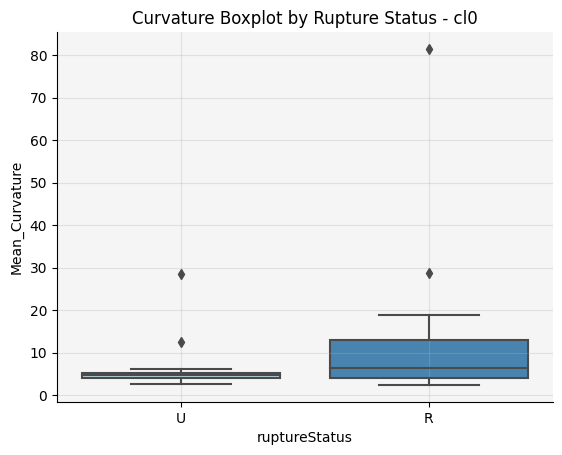

In [289]:
data = cl0_SOM2[['Mean_Curvature', 'ruptureStatus']]
sns.boxplot(x='ruptureStatus', y='Mean_Curvature', data=data, palette="Blues")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status - cl0')

Text(0.5, 1.0, 'Curvature Boxplot by Rupture Status - cl1')

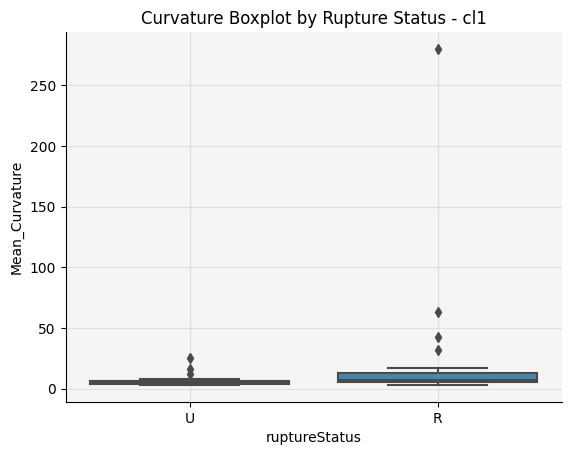

In [290]:
data = cl1_SOM2[['Mean_Curvature', 'ruptureStatus']]
sns.boxplot(x='ruptureStatus', y='Mean_Curvature', data=data, palette="Blues")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.title('Curvature Boxplot by Rupture Status - cl1')

**Comment**:

No evidence of curvature impact on rupture of aneurysms. Confirming the idea stated before that in these patients curvature is not influencing aneurysms.

**Aneurysm Type:**

In [291]:
# aneurysm type

# count the total number of patient per aneurysm type
tot_lat = final_SOM2.groupby('aneurysmType')['aneurysmType'].count()[0]
tot_ter = final_SOM2.groupby('aneurysmType')['aneurysmType'].count()[1]

# count for each cluster
lat_0 = cl0_SOM2.groupby('aneurysmType')['aneurysmType'].count()[0]
lat_1 = cl1_SOM2.groupby('aneurysmType')['aneurysmType'].count()[0]

ter_0 = cl0_SOM2.groupby('aneurysmType')['aneurysmType'].count()[1]
ter_1 = cl1_SOM2.groupby('aneurysmType')['aneurysmType'].count()[1]


pd.DataFrame({'Cluster 0': [lat_0, f'{(lat_0/tot_lat)*100:.2f}%', ter_0, f'{(ter_0/tot_ter)*100:.2f}%'],

              'Cluster 1': [lat_1, f'{(lat_1/tot_lat)*100:.2f}%', ter_1, f'{(ter_1/tot_ter)*100:.2f}%']},

             index = ['Lateral', 'Lateral proportion', 'Terminal', 'Terminal proportion'])

,Cluster 0,Cluster 1
Lateral,12,13
Lateral proportion,48.00%,52.00%
Terminal,20,31
Terminal proportion,39.22%,60.78%


X-Square Test:

In [292]:
contingency_table = pd.crosstab(final_SOM2['Label'], final_SOM2['aneurysmType'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(p_value, chi2)

0.6301723625055862 0.23182709447415292


**Comment**:

No statistical relations, they can be considered independent.

**Radius:**

In [293]:
# check the radius
max_0 = cl0_SOM2['Radius'].max()
max_1 = cl1_SOM2['Radius'].max()

mean_0 = cl0_SOM2['Radius'].mean()
mean_1 = cl1_SOM2['Radius'].mean()

pd.DataFrame({'Cluster 0': [max_0, mean_0],

              'Cluster 1': [max_1, mean_1]},

             index = ['Max Radius', 'Mean Radius'])

,Cluster 0,Cluster 1
Max Radius,3.217234,3.254167
Mean Radius,2.410833,2.239511


ANOVA Assumptions:

In [294]:
# check normality
print('Option 1:\n\n', 'Shapiro Test:\n',
      'cl0: ', scipy.stats.shapiro(cl0_SOM2['Radius']),
      '\ncl1: ', scipy.stats.shapiro(cl1_SOM2['Radius']))

# check homogeneity of variance
print('\n\nHomogeneity of Variance (std):',
      '\ncl0: ', cl0_SOM2['Radius'].std(),
      '\ncl1: ', cl1_SOM2['Radius'].std())

Option 1:

 Shapiro Test:
 cl0:  ShapiroResult(statistic=0.9765439033508301, pvalue=0.6947368383407593) 
cl1:  ShapiroResult(statistic=0.9790875315666199, pvalue=0.5975176692008972)


Homogeneity of Variance (std): 
cl0:  0.37559556495001173 
cl1:  0.3525359535231664


In [295]:
f_oneway(cl0_SOM2['Radius'], cl1_SOM2['Radius'])

F_onewayResult(statistic=4.140935813624884, pvalue=0.045440494706784684)

**Comment**:

Radius is still statistically different if means are compared.

**Aneurysm Location:**

In [296]:
# aneurysm location

# count the total number of patient per aneurysm location
tot_aca = final_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]
tot_bas = final_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
tot_ica = final_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]
tot_mca = final_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[3]


# count for each cluster
aca_0 = cl0_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]
aca_1 = cl1_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[0]

bas_0 = cl0_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]
bas_1 = cl1_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[1]

ica_0 = cl0_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]
ica_1 = cl1_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[2]

mca_0 = cl0_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[3]
mca_1 = cl1_SOM2.groupby('aneurysmLocation')['aneurysmLocation'].count()[3]

pd.DataFrame({'Cluster 0': [aca_0, f'{(aca_0/tot_aca)*100:.2f}%', bas_0, f'{(bas_0/tot_bas)*100:.2f}%', ica_0, f'{(ica_0/tot_ica)*100:.2f}%', mca_0, f'{(mca_0/tot_mca)*100:.2f}%'],

              'Cluster 1': [aca_1, f'{(aca_1/tot_aca)*100:.2f}%', bas_1, f'{(bas_1/tot_bas)*100:.2f}%', ica_1, f'{(ica_1/tot_ica)*100:.2f}%', mca_1, f'{(mca_1/tot_mca)*100:.2f}%']},

             index = ['ACA', 'ACA Proportion', 'BAS', 'BAS Proportion', 'ICA', 'ICA Proportion', 'MCA', 'MCA Proportion'])

,Cluster 0,Cluster 1
ACA,12,10
ACA Proportion,54.55%,45.45%
BAS,1,5
BAS Proportion,16.67%,83.33%
ICA,15,15
ICA Proportion,50.00%,50.00%
MCA,4,14
MCA Proportion,22.22%,77.78%


**Understand in more details:**

Rupture Status by Aneurysm Location:

Cluster 0:

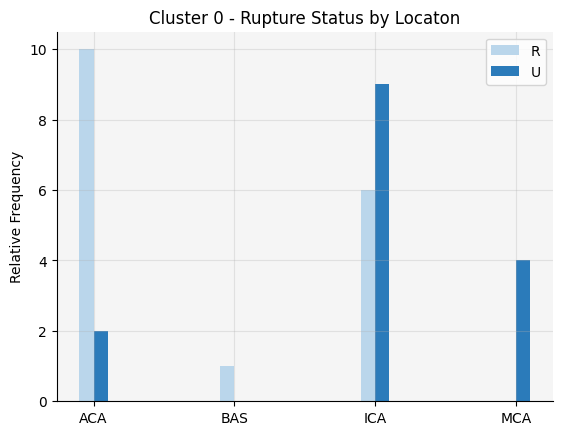

In [297]:
# check the distibution of the rupture aneurysm according to their location

data = pd.crosstab(cl0_SOM2['ruptureStatus'], cl0_SOM2['aneurysmLocation'])

types = ("ACA", "BAS", "ICA", "MCA")
values = {'R': data.values[0].tolist(),
          'U': data.values[1].tolist()}

x = np.arange(len(types))  # the label of locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()

# create color palettes
ruptured_color = sns.color_palette("Blues")[1]
unruptured_color = sns.color_palette("Blues")[4]

# Plot the bars for ruptured
ax.bar(x - width/2, values['R'], width, label='R', color=ruptured_color)

# Plot the bars for unruptured
ax.bar(x + width/2, values['U'], width, label='U', color=unruptured_color)

ax.set_ylabel('Relative Frequency')
ax.set_title('Cluster 0 - Rupture Status by Locaton')
ax.set_xticks(x)
ax.set_xticklabels(types)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
ax.legend()

plt.show()

Cluster 1:

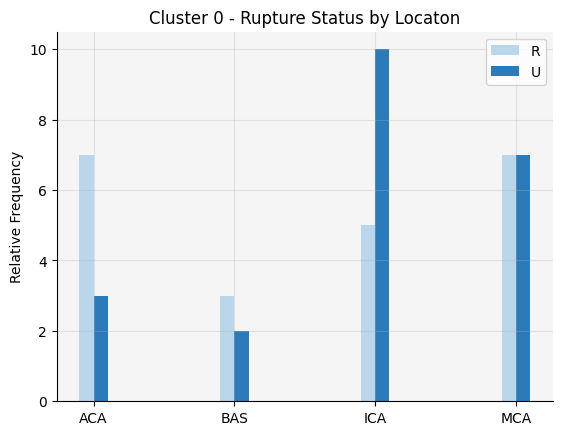

In [298]:
# check the distibution of the rupture aneurysm according to their location

data = pd.crosstab(cl1_SOM2['ruptureStatus'], cl1_SOM2['aneurysmLocation'])

types = ("ACA", "BAS", "ICA", "MCA")
values = {'R': data.values[0].tolist(),
          'U': data.values[1].tolist()}

x = np.arange(len(types))  # the label of locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()

# create the color palettes
ruptured_color = sns.color_palette("Blues")[1]
unruptured_color = sns.color_palette("Blues")[4]

# plot the bars for ruptured
ax.bar(x - width/2, values['R'], width, label='R', color=ruptured_color)

# plot the bars for untuptured
ax.bar(x + width/2, values['U'], width, label='U', color=unruptured_color)

ax.set_ylabel('Relative Frequency')
ax.set_title('Cluster 0 - Rupture Status by Locaton')
ax.set_xticks(x)
ax.set_xticklabels(types)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(True, linestyle='-', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')
ax.legend()

plt.show()

**Comment**:

There is not a clear distribution. Neither regarding rupture, nor regarding position and rupture.